[ 0.54632069 -0.16014396  2.22303934 -0.7925022  -1.2560923   2.05693342
  0.69659414  0.27671281 -1.23116037  1.61024863]
[ 0.54632069 -0.16014396  2.22303934 -0.7925022  -1.2560923   2.05693342
  0.69659414  0.27671281 -1.23116037  1.61024863  9.        ]
0.7820913618585343
0.13480394015651187
1.5152038156895165
1.2164390006131676
0.2
('a', 1)
['adfkj']


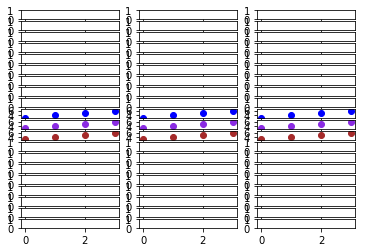

In [142]:
run statistic.ipynb

In [176]:
run io.ipynb

['b', 'c']
['b', 'c']
False
['a', 'b', 'c']
a
False

[[1 2]
 [3 4]]
001


[-0.11748721  0.83806644 -1.01682357 -0.74956483  0.31407638  0.29359071
  0.30137801 -0.51356624 -0.10213106 -0.86497355]
[-0.11748721  0.83806644 -1.01682357 -0.74956483  0.31407638  0.29359071
  0.30137801 -0.51356624 -0.10213106 -0.86497355  9.        ]
0.8328857721493785
0.007678072660829219
2.1123320625506046
0.5786497311219837
0.2
('a', 1)
['adfkj']


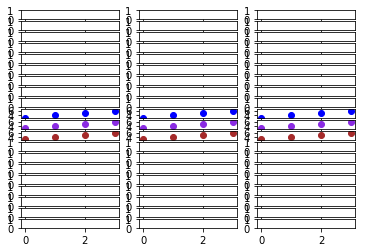

[0 1 0]


In [228]:
run data_anal.ipynb

In [ ]:
# Wrapper of ML kernals for hadron correlators on lattice
import sys
import os
import datetime
import numpy as np
import yaml as yl
import sklearn.ensemble as sle
import sklearn.tree as slt
import matplotlib.pyplot as plot
import math
from itertools import product

RandTrn = []
RandBC = []
RandUnl = []

noSaveRand = True

# Algorithm depend. params
TOL = 1.0e-4
MIN_SSPLIT = 2
# Minimum #fits
MIN_FIT = 1
# Minimum #training data
MIN_TRAIN = 10
# Minimum #bias correction (bc) data
MIN_BC = 10
# Minimum #unlabeled data
MIN_PREDICT = 10
PRINT = False
SHOW = True

# Class to ML fits 
#   pfile: parameter file
class ML_Regression:
    def __init__(self, pfile, RandTrn=[], RandBC=[], RandUnl=[]):
        params = yl.load(pfile)
        # model list: GradiantBoost, DecisionTree, RandomForest, DeepLearning(using Keras)
        self.mllist = ['GB', 'DT', 'RF', 'DL']
        # pick training data set: Jackknife, Bootstrap, Random, k-fold-CrossValidation
        self.tdlist = ['JK', 'BS', 'RM', 'CV', 'CV1']
        try:
            self.estimator = params['estimate']
            self.rate = params['rate']
        except:
            self.estimator = None
            self.rate = None
        try:
            self.rmseed = params['rmseed']
        except:
            self.rmseed = 2018
        #np.random.seed(self.rmseed)
        try:
            self.fixRM = params['fixRM']
        except:
            self.fixRM = False
            #self.rmseed = None
        #self.dfile = params['dfile']
        # method to pick training data set: default to pick first self.trn data
        self.nfit = MIN_FIT
        self.print = PRINT
        self.pre_anly = True
        self.fitter_DL = None
        try:
            self.pred = params['pred']
        except:
            self.pred = True
        self.incbc = True
        try:
            self.tdset = params['tdset']
            #print(self.tdset)
            if self.tdset in self.tdlist:
                try:
                    self.nfit = params['nfit']
                except:
                    self.nfit = MIN_FIT
                if self.tdset == 'JK':
                    # Jackknife index
                    try:
                        self.itdpar = params['tdpar']
                    except:
                        self.itdpar = 0
                    self.tdpar = self.itdpar-1
                    self.jk = False
                if self.tdset == 'BS':
                    self.nfit += 1
                    self.bs = False
                    try:
                        self.fixbs = params['fixRM']
                    except:
                        self.fixbs = False
                    if self.fixbs: 
                        self.Rtrn = RandTrn
                        self.Rbc = RandBC
                        self.Runl = RandUnl
                # k-fold Cross-validation: 5 <= k <= 10
                if 'CV' in self.tdset:
                    if self.nfit > 10:
                        self.nfit = 10
                    #if self.nfit < 5:
                    #    self.nfit = 5
                    self.nfit += 1
                    try:
                        self.incbc = params['includeBC']
                    except:
                        self.incbc = False
                    self.cv = False
                    try:
                        self.fixcv = params['fixRM']
                    except:
                        self.fixcv = False
                    if self.fixcv:
                        self.Rm = RandTrn
            elif not isinstance(self.tdset, int):
                print('Warning: Unknown training data subset identifier! Set to 0\n')
                self.tdset = 0
        except:
            self.tdset = 0
        print(self.tdset)
        try:
            self.odir = params['odir']
            self.osave = True
        except:
            self.osave = False
            self.ofile = None
        self.pdir = params['pdir']
        self.mlml = params['mlml']
        pdfile = open(self.pdir+'/'+self.mlml,'r')
        self.pf = yl.load(pdfile)
        pdfile.close()
        try:
            self.anal = params['analysis']
        except:
            self.anal = False
        if self.anal: 
            self.post_anal = ML_Analyze_PDF(params)
            self.save_tmpfits = True
            try:
                self.effmass = params['effmass']
            except:
                self.effmass = False
            try:
                self.ratio = params['ratio']
            except:
                self.ratio = False
        # list of Y momentum
        self.prY = params['momentum_Y']
        # list of Y z's
        self.zrY = params['z_Y']
        try:
            self.prX = params['momentum_X']
            if len(list(self.prX)) == 0:
                self.prX = None
        except:
            self.prX = None
        try:
            self.zrX = params['z_X']
            if len(list(self.zrX)) == 0:
                self.zrX = None
        except:
            self.zrX = None
        try:
            self.orY = params['operator_Y']
            if len(list(self.orY))==0:
                self.orY = [None]
        except:
            self.orY = [None]
        try:
            self.orX = params['operator_X']
            if len(list(self.orX))==0:
                self.orX = [None]
        except:
            self.orX = [None]
        try:
            self.srY = params['T_Y']
        except:
            self.srY = [None]
        try:
            self.srX = params['T_X']
        except:
            self.srX = [None]
        # list of Y time slices
        try:
            self.tr = params['ts_Y']
            if self.tr is None:
                self.tr = [None]
            elif len(list(self.tr)) == 0:
                self.tr = [None]
        except: 
            self.tr = [None]
        # list of X & Y time differences
        self.dtr = params['dts_X']
        # number of sources per configuration
        try:
            self.tfold = params['nsrc']
        except:
            self.tfold = 0
        self.ntrn = params['ntrn']
        if isinstance(self.ntrn, (int, str)):
            assert(int(self.ntrn) >= MIN_TRAIN)
            self.ntrn = [int(self.ntrn)]
        else:
            assert(len(self.ntrn) == len(self.prX))
        self.nbc = params['nbc']
        if isinstance(self.nbc, (int, str)):
            assert(int(self.nbc) >= MIN_BC)
            self.nbc = [int(self.nbc)]
        else:
            assert(len(self.nbc) == len(self.prX))
        # read in data stored in data pool 'database'
        # params[]: 
        #     format (data format, 'raw','pdf'); 
        #     binsize (data bin); 
        #     ddir (data files directory)
        #     dfile.x (X data filename); 
        #     dfile.y (Y data filename);
        self.database = Data_IO(params, self.tdset)
        self.data = None
        self.ndata = 0
        self.model = None
        self.fitnow = None
        self.isset = False
        self.errscale = None
        self.date = self.database.date #datetime.datetime.today().strftime('%m%d%Y')
        # Data IO, moved to the io kernel 
        return
    
    # clear data, free memory
    def finalize(self): 
        if self.anal: 
            self.post_anal.finalize()
        self.cleanup_data()
        self.del_data()
        self.database.finalize()
        if (self.tdset == 'BS') and (self.fixbs is True):
            del self.Rtrn
            del self.Rbc
            del self.Runl
            self.Rtrn = None
            self.Rbc = None
            self.Runl = None
        if 'CV' in self.tdset:
            del self.Rm
            self.Rm = None
        return
        
    # Initialize fits
    # Select correlator characters, p (momentum), z (Wilson link lenght), t (sink time slice), etc., 
    #        data sets, and assign the fit model
    def inifit(self, fdparX, fdparY, indx):
        self.ftag = None
        self.dtag = None
        self.p = None
        self.c = None
        self.y = None
        if self.del_data: 
            self.data = {}
            self.add2pt = False
            if self.ratio:
                #print("Y tags are {:}".format(fdparY))
                deltagY, self.ftag, self.spectag, self.data['Y'], self.data['S'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = len(self.spectag)
                self.add2pt = (self.n2pt > 0)
            else:
                deltagY, self.ftag, self.data['Y'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = 0
            if self.data['Y'].shape[0]==0:
                self.ny=0
                self.nx=0
                self.fitnow = self.nfit
                return
            self.dtX, self.dtag, self.data['X'], self.dmeanX, self.dstdX = self.database.select_data(fdparX, 'X')       
        #print("self.data['X'] is {:}".format(self.data['X']))
        self.ndata = self.data['X'].shape[0]
        if self.ndata > self.data['Y'].shape[0]:
            self.ndata = self.data['Y'].shape[0]
        if 'CV' in self.tdset:
            self.mlscr = []
            self.mlscr0 = []
            self.cvbs = []
            self.cv = False
            #if self.ndata / (self.nfit-1) < 50:
             #   self.nfit = int(self.ndata/50.0) + 1
        self.nx = self.data['X'].shape[1]
        self.ny = len(self.ftag) #self.data['Y'].shape[1]
        self.Ny = self.n2pt + self.ny
        print("Shape of X / Y : {:} / {:}".format(self.nx, self.ny))
        try:
            self.trn = self.ntrn[indx]
        except:
            self.trn = self.ntrn[0]
        try:
            self.bc = self.nbc[indx]
        except:
            self.bc = self.nbc[0]
        self.lbl = self.trn + self.bc
        self.unlbl = self.ndata - self.lbl
        if self.tdset == 'JK':
            self.nfit = int(self.trn) + 1
            self.tdpar = self.itdpar-1
            self.jk = False
        if self.tdset == 'BS':
            self.bs = False
        # verify number of train & test data
        if ('CV' in self.tdset) and (int(self.ndata / self.unlbl) != self.nfit-1):
            if self.tdset == 'CV':
                self.unlbl = int(self.ndata/(self.nfit-1))
                self.lbl = self.ndata - self.unlbl
            else:
                self.lbl = int(self.ndata/(self.nfit-1))
                self.unlbl = self.ndata - self.lbl
            if self.incbc:
                self.trn = int(self.trn*self.lbl/(self.trn+self.bc))
                self.bc = self.lbl-self.trn
            else:
                self.trn = self.lbl
                self.bc = 0
        self.bin = int((self.ndata+self.lbl-1)/self.lbl)
        self.data_reorder()
        if self.tdset == 'JK' or self.tdset == 'RM':
            self.N = self.data['X'][self.lbl:]
            self.P = self.data['Y'][self.lbl:]
        if self.model != None:
            del self.model
        self.model = self.make_model(indx)
        self.isset = False
        self.errscale = None
        self.fitnow = 0
        if self.osave:
            self.database.dfile_mkheader(indx)
            self.ml_mkheader()
        if self.anal:
            print("Adding table")
            self.post_anal.add_table(self.database.NT, self.ndata, self.trn, self.bc, pztY=self.ftag, pztX=self.dtag)
            print("Finishing adding table")
            
    def isfit(self):
        return self.fitnow < self.nfit
        
    # Reorder data (scatter)
    def data_reorder(self):
        tmpx = self.data['X']
        tmpy = self.data['Y']
        self.data['X'] = []
        self.data['Y'] = []
        if self.add2pt:
            tmps = self.data['S']
            self.data['S'] = []
        for i in range(4):#self.bin):
            self.data['X'].extend(tmpx[i:self.ndata:4])#self.bin])
            self.data['Y'].extend(tmpy[i:self.ndata:4])#self.bin])
            if self.add2pt:
                self.data['S'].extend(tmps[i:self.ndata:4])#self.bin])
        del tmpx
        del tmpy
        if self.add2pt:
            del tmps

    # build up the fit model
    def make_model(self, indx=None):
        assert(self.mlml in self.mllist) 
        if self.mlml == 'GB':
            return self.make_model_GB(indx)
        elif self.mlml == 'DT':
            return self.make_model_DT()
        elif self.mlml == 'RF':
            return self.make_model_RF()
        else:
            return self.make_model_DL()
        
    def ml_mkheader(self):
        if self.osave is False: 
            return
        pf = open(self.database.ofile, 'a')
        if self.mlml == 'GB': 
            pf.write("\n GB parameters: (random seed {:}) \n nestimator:  {:} \n \
            lnrate:  {:} \n lossfunc:  {:} \n subsample:  {:} \n \
            max_depth:  {:} \n lntol:  {:} \n verbose:  {:} \n\n".format(self.rmseed, self.GB_nestimator, 
                                                                         self.GB_lnrate, self.GB_lossfunc, self.GB_ssample, 
                                                                         self.GB_mdth, self.GB_tol, self.GB_verbose))
        pf.close()
        return
    
    # Gradient Boosting
    def make_model_GB(self, indx=None):
        if indx is None:
            self.GB_nestimator = self.pf['nestimator']
            self.GB_lnrate = self.pf['lnrate']
        else:
            try:
                self.GB_nestimator = self.estimator[indx]
                self.GB_lnrate = self.rate[indx]
            except:
                self.GB_nestimator = self.pf['nestimator']
                self.GB_lnrate = self.pf['lnrate']
        try:
            self.GB_lossfunc = self.pf['lossfunc']
        except:
            self.GB_lossfunc = 'ls'
        try:
            self.GB_ssample = self.pf['subsample'] #= float(self.trn) / float(self.ndata)
            GB_schn = int(10/self.GB_ssample)
        except:
            self.GB_ssample = 1.0
            GB_schn = 1
        try:
            self.GB_mdth = self.pf['max_depth']
        except:
            self.GB_mdth = 3
        try:
            self.GB_tol = self.pf['lntol']
        except:
            self.GB_tol = TOL
        try:
            self.GB_verbose = self.pf['verbose']
        except:
            self.GB_verbose = False
        print("GB parameter rate is {:}".format(self.GB_lnrate))
        model = [ sle.GradientBoostingRegressor(loss=self.GB_lossfunc, learning_rate=self.GB_lnrate, 
                                             n_estimators=self.GB_nestimator, max_depth=self.GB_mdth, 
                                             subsample=self.GB_ssample,
                                            tol=self.GB_tol) #for j in range(GB_schn) ]
                 for i in range(self.ny) ]
        #self.ml_mkheader()
        return model
        
    # Decistion Tree
    def make_model_DT(self):
        try:
            self.DT_ctr = self.pf['criterion']
        except:
            self.DT_ctr = 'mse'
        self.DT_mdth = None
        self.DT_mspt = None
        try:
            self.DT_mspt = self.pf['min_samples_split']
        except:
            try:
                self.DT_mdth = self.pf['max_depth']
                self.DT_mspt = None
            except:
                self.DT_mspt = MIN_SSPLIT
                self.DT_mdth = None
        try:
            self.DT_verbose = self.pf['verbose']
        except:
            self.DT_verbose = False
        model = [ slt.DecisionTreeRegressor(criterion=self.DT_ctr, max_depth=self.DT_mdth,
                                        min_samples_split=self.DT_mspt)
                 for i in range(self.ny) ]
        return model
            
    # Random Foreast
    def make_model_RF(self):
        # FIXME
        return None
    
    def make_model_DL(self):
        self.fitter_DL = DL_Regression(self.pf, self.ny)
        return self.fitter_DL.model
    
    def make_oheader(self, parY, parX, indx):
        self.database.dfile_mkheader()
        self.ml_mkheader()
        return
    
    # set up data: Train [X,Y]; BC [B,C]; Unlabeled [N,P]
    def setup_data(self):
        self.fitnow += 1
        if self.save_tmpfits: 
            self.post_anal.append_table(self.database.odir)
        if self.isset:
            return True
        if isinstance(self.tdset, int):
            try:
                self.X = self.data['X'][self.tdset:self.tdset+self.trn]
                self.Y = self.data['Y'][self.tdset:self.tdset+self.trn]
                self.B = self.data['X'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                self.C = self.data['Y'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                if self.add2pt:
                    self.S = self.data['S'][self.tdset:]
            except:
                print('Labeled data subset out of index range!\n')
                sys.exit()
            self.N = list(self.data['X'][self.tdset+self.lbl:])
            self.P = list(self.data['Y'][self.tdset+self.lbl:])
            if self.tdset > 0:
                self.N.extend(self.data['X'][:self.tdset])
                self.P.extend(self.data['Y'][:self.tdset])
                if self.add2pt:
                    self.S.extend(self.data['S'][:self.tdset])
            self.tdset+=1
        else:
            if self.tdset == 'JK':
                if self.jk: 
                    self.X = []
                    self.Y = []
                    if self.add2pt:
                        self.S = []
                    self.tdpar+=1
                    if self.tdpar < 0 or self.tdpar > self.trn:
                        return self.isset
                    if self.tdpar > 0:
                        self.X.extend(self.data['X'][:self.tdpar])
                        self.Y.extend(self.data['Y'][:self.tdpar])
                        if self.add2pt:
                            self.S.extend(self.data['S'][:self.tdpar])
                    if self.tdpar < self.trn:
                        self.X.extend(self.data['X'][self.tdpar+1:self.trn+1])
                        self.Y.extend(self.data['Y'][self.tdpar+1:self.trn+1])
                        if self.add2pt:
                            self.S.extend(self.data['S'][self.tdpar+1:self.trn+1])
                    self.B = []
                    self.C = []
                    self.B.extend(self.data['X'][self.trn+1:self.lbl])
                    self.B.append(self.data['X'][self.tdpar])
                    self.C.extend(self.data['Y'][self.trn+1:self.lbl])
                    self.C.append(self.data['Y'][self.tdpar])
                    if self.add2pt:
                        self.S.extend(self.data['S'][self.trn+1:self.lbl])
                        self.S.append(self.data['S'][self.tdpar])
                        self.S.extend(self.data['S'][self.lbl:])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    #self.N = self.data['X'][self.lbl:]
                    #self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.jk = True
                print("Dimensions: X {:} Y {:} B {:} C {:} N {:} P {:} S {:}\n\n".format(np.array(self.X).shape, 
                                                                                    np.array(self.Y).shape,
                                                                                    np.array(self.B).shape,
                                                                                    np.array(self.C).shape,
                                                                                    np.array(self.N).shape,
                                                                                    np.array(self.P).shape,
                                                                                        np.array(self.S).shape))
            elif self.tdset == 'BS':
                if self.bs:
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if self.fixbs:
                        if len(self.Rtrn) < self.nfit-1:
                            self.Rtrn.append(np.random.randint(0, self.lbl, self.trn))
                            #RandTrn = np.array(self.Rtrn)
                            #print("RandTrn is {:}".format(RandTrn))
                        if len(self.Rbc) < self.nfit-1:
                            self.Rbc.append(np.random.randint(0, self.lbl, self.bc))
                            #RandBC = np.array(self.Rbc)
                            #print("RandBC is {:}".format(RandBC))
                        if len(self.Runl) < self.nfit-1: 
                            self.Runl.append(np.random.randint(self.lbl,self.ndata, self.unlbl))
                            #RandUnl = np.array(self.Runl)
                            #print("RandUnl is {:}".format(RandUnl))
                    for i in range(self.trn):
                        if self.fixbs:
                            r = self.Rtrn[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        if self.fixbs:
                            r = self.Rbc[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        #r = np.random.randint(0,self.lbl)
                        #print("Rand is {:}".format(r))
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        if self.fixbs:
                            r = self.Runl[self.fitnow-2][i]
                        else:
                            r = np.random.randint(self.lbl,self.ndata)
                        #r = np.random.randint(self.lbl,self.ndata)
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.bs = True
            elif self.tdset == 'CV':
                if (self.fitnow-1)*self.unlbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.unlbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[(stcv+self.unlbl+i)%self.ndata]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.unlbl+self.trn+i)%self.ndata]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            elif self.tdset == 'CV1':
                if (self.fitnow-1)*self.lbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.lbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[stcv+i]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.trn+i)]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+self.lbl+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            else:
                pm = np.random.permutation(self.lbl)
                self.X = [self.data['X'][pm[i]] for i in range(self.trn)]
                self.B = [self.data['X'][pm[i]] for i in range(self.trn,self.lbl)]
                self.Y = [self.data['Y'][pm[i]] for i in range(self.trn)]
                self.C = [self.data['Y'][pm[i]] for i in range(self.trn,self.lbl)]
                if self.add2pt:
                    self.S = [ self.data['S'][i] for i in pm ]
        self.isset = True
        return self.isset
        
    def del_data(self):
        if self.data == None:
            return True
        if 'X' in self.data:
            del self.data['X']
        if 'Y' in self.data:
            del self.data['Y']
        if 'S' in self.data:
            del self.data['S']
        self.data = None
        try:
            del self.mlscr
            del self.mlscr0
            del self.cvbs
        except:
            pass
        del self.dmeanX
        del self.dmeanY
        del self.dstdY
        del self.dstdX
        self.dmeanX = None
        self.dmeanY = None
        self.dstdY = None
        self.dstdX = None
        return True
    
    # clean up data
    def cleanup_data(self):
        if self.isset is False:
            return 
        if self.tdset in self.tdlist:
            del self.X
            del self.Y
            del self.B
            del self.C
        if self.tdset == 'BS' or isinstance(self.tdset, int):
            del self.N
            del self.P
        if self.y is not None:
            del self.y
            del self.c
            del self.p
            self.y = None
            self.c = None
            self.p = None
        if self.add2pt:
            del self.S
        self.isset = False
        return
    
    # Plot data statistics: histograms, density, correlations
    def data_statistic(self, data, tag = None):
        ddf = Dataframe(data, tag=tag)
        print(ddf.data.describe())
        binmin, atc = ddf.autocorr(0.1)
        print('Data blocksize {:d} with autocorrelation {:f} \n'.format(binmin, atc))
        print("self.nx is {:}".format(self.nx))
        ddf.hist((self.nx,None),self.database.pltfile)
        ddf.density((self.nx,None),self.database.pltfile)
        ddf.covplot(prange=((0, self.nx), (self.nx, None)), out=self.database.pltfile)
        return
        

    # Prediction bias Correction
    def bias_crrt(self):
        if self.c is not None:
            del self.c
            self.c = None
        if self.p is not None:
            del self.p
            self.p = None
        if self.y is not None:
            del self.y
            self.y = None
        if self.incbc:
            self.c = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.B).tolist()) 
                            for i in range(self.ny)])
        self.p = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist()) 
                            for i in range(self.ny)])
        # Cross-validation: Add prediction scores
        if 'CV' in self.tdset and self.cv:
            self.mlscr.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist(), np.array(self.P).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.mlscr0.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), np.array(self.Y).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.cvbs.append(np.array(self.Y).mean(axis=0) - self.p.mean(axis=1))
        if self.incbc:
            C_arr = np.ndarray(shape=(self.bc,self.ny),buffer=np.array(self.C)).T
        # Prediction matrix of size ny*ndata
        self.y = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist()) 
                            for i in range(self.ny)])
        predata = np.array([self.model[i].predict(
            self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist())  
                            for i in range(self.ny)])
        print(predata.shape)
        omat = np.ndarray(shape=(2*self.ny, self.ndata), 
                          buffer=np.array([
                              predata.tolist(), 
                              np.array(self.data['Y']).T.tolist()]))
                     #     dtype=float)
        # generate covariance matrix, predictions first
        ocov = np.cov(omat)
        print('shape of OCOV: {:}'.format(ocov.shape))
        if self.incbc:
            # Bias correction equation
            obc = np.array([self.p[i].mean() + C_arr[i].mean() - self.c[i].mean() for i in range(self.ny)])
            for o in obc:
                print(o)
        else:
            obc = np.array([self.p[i].mean() for i in range(self.ny)])
        s2 = np.array([ocov[i,i]/ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        r = np.array([(ocov[i,i+self.ny]**2/(ocov[i,i]*ocov[i+self.ny,i+self.ny])) for i in range(self.ny)])
        osigma = np.array([ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        srs2r = np.array([math.sqrt(s2[i]*r[i]) for i in range(self.ny)])
        if self.incbc:
            bcvar = osigma/self.lbl*(s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)
        else:
            bcvar = osigma*s2/self.unlbl
        if self.errscale is None:
            if self.incbc:
                self.errscale = (s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)/self.lbl
            else:
                self.errscale = s2*self.lbl/self.unlbl
            self.errscale = np.array([math.sqrt(self.errscale[i]) for i in range(self.ny)])
            print("Correlation coefficient between Pred. & Obsd. {:}".format([math.sqrt(r[i]) for i in range(self.ny)]))
            print("error scale: {:}".format(self.errscale))
            if False: #if self.anal:
                self.post_anal.extend_table('errscl', self.errscale)
            if self.osave: 
                pf = open(self.database.ofile, 'a+')
                pf.write("Correlation coefficient between Pred. & Obsd. {:}\n".format([math.sqrt(r[i]) for i in range(self.ny)]))
                pf.write("error scale: {:}\n".format(self.errscale))
                pf.close()
        return (obc, np.array([math.sqrt(bcvar[i]) for i in range(self.ny)]))
    
    def imp_prdt(self, bc):
        return bc
    
    def add_anal(self):
        if self.save_tmpfits:
            #self.post_anal.extend_table({"ycov": ocov})
          #  self.post_anal.extend_table({"ymean": obc})
           # self.post_anal.extend_table({"y": omat})
            if False: #for i in range(self.ny):
                print("{:}: {:}".format(self.ftag[i], np.array(self.Y).T[i]))
            if self.incbc:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=np.array(self.Y).T, dbc=np.array(self.C).T, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            else:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=np.array(self.Y).T, dbc=None, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            if self.pred:
                if self.incbc:
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=self.y, dbc=self.c, 
                                    dunlbl=self.p, pred=None, overwrite=True)
                else:
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dmeanY, 
                                    dtrn=self.y, dbc=None, 
                                    dunlbl=self.p, pred=True, overwrite=True)
            if self.effmass:
                self.post_anal.effmass(tag=self.ftag, pred=False)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=1)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=2)
                
                if self.pred:
                    self.post_anal.effmass(tag=self.ftag, pred=True)
                    if self.incbc:
                        self.post_anal.effmass(tag=self.ftag, pred=None)
            if self.ratio:
                if self.add2pt:
                    self.post_anal.add_data(tag=self.spectag, #dscale=self.dmeanY, 
                                        #dtrn=np.array(self.Y).T[self.ny:,:], 
                                        #dbc=np.array(self.C).T[self.ny:,:], dunlbl=np.array(self.P).T[self.ny:,:], 
                                        data=np.array(self.S).T, 
                                        pred=False, NT=self.database.NT, is2pt=True)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=False)
                if self.pred:
                    if self.incbc:
                        self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=None)
                    self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=True)
        return
        
    # Post-fits analysis
    def analyze(self, bc, pd):
        if self.ny==0:
            return
        if self.osave:
            pf = open(self.database.ofile, 'a+')
        if self.pred:
            scr = np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist(), 
                np.array(self.data['Y']).T.tolist()[i]) for i in range(self.ny)])
            # Cross-validation: Prediction score statistics
            if 'CV' in self.tdset:
                scrmean = np.array(self.mlscr).mean(axis=0)
                scrmean0 = np.array(self.mlscr0).mean(axis=0)
                scrstd = np.array(self.mlscr).std(axis=0,ddof=1)
                scrstd0 = np.array(self.mlscr0).std(axis=0,ddof=1)
                bs = np.array(self.cvbs).mean(axis=0) * self.dmeanY
                bss = np.array(self.cvbs).std(axis=0,ddof=1) * self.dmeanY#/abs(bs)
            if self.tdset == 'BS' or self.tdset == 'JK':
                oimp = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[::2]).T
                print("OIMP is {:}\n".format(oimp))
                omean = np.array([oimp[i].mean() for i in range(self.ny)])
                #print(omean)
                ostd = np.array([oimp[i].std(ddof=1) for i in range(self.ny)])
                if self.tdset == 'BS':
                    print(pd[0][0])
                    obc = 2.*pd[0][0]-omean
                else:
                    obc = omean #self.lbl*pd[0][0]-(self.lbl-1)*omean
                    print("OBC is {:}\n".format(obc))
                    ostd *= (len(oimp)-1)/math.sqrt(float(self.unlbl))
            else:
                #oimp = np.array(pd[:][0]).T
                oimp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[::2]).T
                obc = np.array([oimp[i].mean() for i in range(self.ny)])
                simp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[1::2]).T
                ostd = np.array([[oimp[i].std(ddof=1), simp[i].mean()] for i in range(self.ny)])
            self.res = (scr, obc, ostd)
            oy = np.array(self.data['Y']).T
            oymean = np.array([oy[i].mean() for i in range(self.ny)]) * self.dmeanY
            #oystd = np.array([oy[i].std(ddof=1) for i in range(self.ny)]) * self.dmeanY/math.sqrt(self.unlbl)
            oystd = self.dstdY / math.sqrt(float(self.unlbl))
            if False:
                print("Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
               \t {:} (re)sampling {:d} fits \n \
               \t score = {:}; Predicted Mean / Observed: \
               \t {:} +- {:} / {:} +- {:} \n".format(self.nx, self.ndata, self.trn,self.bc, self.unlbl, 
                                                             self.tdset, self.nfit, 
                                                             scr, obc*self.dmeanY, ostd*abs(self.dmeanY),  
                                                             oymean, oystd))
            IR = ['R', 'I']
            if 'CV' in self.tdset:
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t scrall = {:}; \n \
                    \t score = {:}; \n scrstd = {:}; \n\
                    \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr, scrmean0, scrstd0))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                              oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
            else:
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t score = {:}; \n \
                    \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} ".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                              oymean[i], oystd[i]))
            print('\n\n')
            if 'CV' in self.tdset:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t scrall = {:}; \n \
                \t score = {:}; \n scrstd = {:}; \n\
                \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr, scrmean0, scrstd0))#scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}\n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                          oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
            else:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t score = {:}; \n\
                \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dmeanY[i], ostd[i]*abs(self.dmeanY[i]), 
                                                                          oymean[i], oystd[i]))
        else:
            print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
            if self.osave:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
        if self.osave:
            if self.anal:
                if self.effmass:
                    self.post_anal.print_effmass(self.tdset, pf, ppf=self.database.pltfile)
                if self.ratio:
                    self.post_anal.print_ratio3ptn2pt(self.tdset, pf, ppf=self.database.pltfile)
            pf.write("\n\n\n")
            pf.close()
        if self.anal:
            print("Merge tables")
            self.post_anal.merge_table()
            print("Finished merging tables")
            # no need to save current analysis results
            self.post_anal.drop_table()
    
    def print_fit(self, pd):
        for r in pd:
            print(r)
    
    # Do fits
    def fit(self):
        res = []
        bc = []
        pd = []
        n=0
        while self.isfit(): #for i in range(self.nfit):
            if self.setup_data():
                # Print data statistics
                if False:#n == 1:
                    print("Training data statistic\n")
                    data = {}
                    data['X'] = np.array(self.X).reshape(self.trn, self.nx)
                    data['Y'] = np.array(self.Y).reshape(self.trn, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Bias correction data statistic\n")
                    data['X'] = np.array(self.B).reshape(self.bc, self.nx)
                    data['Y'] = np.array(self.C).reshape(self.bc, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Unlabeled data statistic\n")
                    data['X'] = np.array(self.N).reshape(self.unlbl, self.nx)
                    data['Y'] = np.array(self.P).reshape(self.unlbl, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                # yield to DL fitter
                if self.fitter_DL is not None:
                    res.append(self.fitter_DL.fit(self.X, self.Y, self.B, self.C))
                elif self.pred:
                    print("ny = {:}".format(self.ny))
                    res.append(np.array([self.model[i].fit(
                        self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), 
                        np.array(self.Y).T.tolist()[i]) for i in range(self.ny)]))
                #print(res[-1])
                    bc.append(self.bias_crrt())
                    print(bc[-1])
                    pd.append(self.imp_prdt(bc[-1]))
                    print(pd[-1])
                self.add_anal()
                if False:#n == 1:
                    print("Predicted data statistics\n")
                    data = {'X': np.array(self.N).reshape(self.unlbl,self.nx), 'Y': np.array(self.p).T}
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                self.cleanup_data()
                if self.print:
                    self.print_fit(pd)
                n+=1
        if self.anal: 
            self.analyze(bc, pd)
        return

    def show_fit(self):
        return
            
    # runs over loops of input parameters
    def run(self):
        tlist = (tuple, list)
        print("Running ML...\n")
        for pi in range(len(self.prY)):
            try:
                oy = self.orY[pi]
            except:
                oy = self.orY[0]
            try:
                ox = self.orX[pi]
            except:
                ox = self.orX[0]
            if isinstance(self.prY[pi], tlist):
                py = self.prY[pi]
            else:
                py = [self.prY[pi]]
            if self.prX is None:
                px = None
            else:
                try:
                    px = self.prX[pi]
                except:
                    px = self.prX[0]
            if isinstance(self.zrY[pi], tlist):
                zy = list(self.zrY[pi])
            else:
                zy = [self.zrY[pi]]
            if self.zrX is None:
                zx = None
            else:
                try:
                    zx = self.zrX[pi]
                except:
                    zx = self.zrX[0]
            print("X z's is {:}".format(zx))
            if False:
                if isinstance(self.zrX[pi], tlist):
                    zx = list(self.zrX[pi])
                else:
                    zx = [self.zrX[pi]]
            for tsp in range(len(self.srY)):
                if isinstance(self.srY[tsp], tlist):
                    tsy = list(self.srY[tsp])
                else:
                    tsy = [self.srY[tsp]]
                try:
                    if isinstance(self.srX[tsp], tlist):
                        tsx = list(self.srX[tsp])
                    else:
                        tsx = [self.srX[tsp]]
                except:
                    tsx = self.srX[0]
                for ti in range(len(self.tr)):
                    if isinstance(self.tr[ti], tlist):
                        ty = list(self.tr[ti])
                    else:
                        ty = [self.tr[ti]]
                    if None in ty:
                        ty = None
                    try:
                        if isinstance(self.dtr[ti], tlist):
                            dtx = self.dtr[ti]
                        else:
                            dtx = self.dtr
                    except:
                        dtx = self.dtr
                    if False:
                        tx = []
                        for t,dt in product(ty, dtx):
                            tx.append(t+dt)
                        ttx = np.array(tx)
                        ttx.sort()
                        del tx
                        tx = []
                        tx.append(ttx[0])
                        for i in range(1, ttx.size):
                            if ttx[i] != tx[-1]:
                                tx.append(ttx[i])
                    parX = [ox, px, zx, tsx, ty, dtx]
                    parY = [oy, py, zy, tsy, ty, None]
                    print(py)
                    print(zy)
                    self.inifit(parX, parY, pi)
                    #if True: #self.pre_anly:
                    #    self.data_statistic(self.data)  
                    self.fit()
                    if SHOW:
                        self.show_fit()
                # spectrum only, ignore loop over 'T'
                if zy == [self.database.NA]:
                    break
        return

   

def main(pfile, RandTrn, RandBC, RandUnl, noSaveRand):
    ml = ML_Regression(pfile, RandTrn, RandBC, RandUnl)
    ml.run()
    RandTrn = []
    RandBC = []
    RandUnl = []
    if noSaveRand is False:
        if ml.tdset == 'BS':
            RandTrn = ml.Rtrn.copy()
            RandBC = ml.Rbc.copy()
            RandUnl = ml.Runl.copy()
            pf = open('/Users/ruizi/Documents/ML/Samples.train', 'a')
            pf.write('{:}\n\n'.format(ml.Rtrn))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.bc', 'a')
            pf.write('{:}\n\n'.format(ml.Rbc))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.unlabel', 'a')
            pf.write('{:}\n\n'.format(ml.Runl))
            pf.close()
        elif 'CV' in ml.tdset:
            RandTrn = ml.Rm.copy()
    ml.finalize()
    return RandTrn, RandBC, RandUnl
        
if __name__ == '__main__':
    if False:#for j in range(2):
        for i in [250, 500, 750, 1000]:
            main(open('/Users/ruizi/Documents/ML/input.pda.test.'+str(i),'r')) 
    noSaveRand = True
    RandTrn = []
    RandBC = []
    RandUnl = []
    for ff in [ "pdf.kaon.ave" ]:#, "pdf.z0"]:
        #for ntrn, nbc in product([50, 40], [100, 80, 60, 40]): #[ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001 ], [100, 200, 300, 400]): #ff in ["pdf.k3"]: 
        RandTrn = []
        RandBC = []
        RandUnl = []
        if 'pdf' in ff:
            for ntrn, nbc in product([100], [100]):
                pf = open('/Users/ruizi/Documents/ML/input.'+ff,'a')
                pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                pf.close()
                RandTrn = []
                RandBC = []
                RandUnl = []
                for rate, estm in product([0.1], [100]):
                    pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
                    pf.write("lnrate: {:}\nnestimator: {:}\n".format(rate, estm))
                    pf.close() 
                    noSaveRand = False
                    RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff,'r'), RandTrn, RandBC, RandUnl, noSaveRand) 
        else:
            for rate, estm in product([ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):#[0.1, 0.01], [100, 300]):
            #RandTrn = []
            #for nbc in [100, 80, 60, 40]: 
            #RandBC = []
            #RandUnl = []
            #for rate, estm in product([0.1, 0.01], [100, 300]):
                pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
                pf.write("lnrate: {:}\nnestimator: {:}\n".format(rate, estm))
                pf.close()
                #pf = open('/Users/ruizi/Documents/ML/input.'+ff,'a')
                #pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                #pf.close()
                if True:#if 'pdf' in ff:
                    noSaveRand = False
                RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff,'r'), RandTrn, RandBC, RandUnl, noSaveRand) 
                print(noSaveRand)
    #for i in range(2,9):
     #   main(open('/Users/ruizi/Documents/ML/input.'+str(i),'r'))      


JK
self.ave is False
Running ML...

X z's is {'mg5': ['None'], 'g8': [0, 201, 202, 203, 601, 602, 603]}
[4]
[204]
ofs = 1
list of olkeys is    {'g8': {'g8.m-0.075_im-0.019938': ['m-0.075_m-0.019938.mg5']}}


pll is [4] zll is [204, 'None']
Number of data are [495, 495]
Number of data is 495
[4]
list of z [204, 'None']
ofs = 1
list of olkeys is    {'g8': ['g8.m-0.075_im-0.019938'], 'mg5': ['m-0.075_m-0.019938.mg5']}


pll is [4] zll is [0, 201, 202, 203, 601, 602, 603]
pll is [4] zll is ['None']
Number of data are [495, 495, 495, 495, 495, 495, 495, 495]
Number of data is 495
{'g8': [4], 'mg5': [4]}
list of z {'mg5': ['None'], 'g8': [0, 201, 202, 203, 601, 602, 603]}
Shape of X / Y : 116 / 12
GB parameter rate is 0.1
Adding table
Finishing adding table
Dimensions: X (100, 116) Y (100, 12) B (100, 116) C (100, 12) N (295, 116) P (295, 12) S (495, 32)


ny = 12
(12, 495)
shape of OCOV: (24, 24)
1.1017227176089648
1.0992678953745636
1.1032257257098368
1.1004416572824016
1.1017220224979167


/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

U

Make heatmap plots on fitting scores for each channel of fits

channel 0
file length is 20


/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:89: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessor

Y0.R.0 variance
            100       200       300       400
0.5    0.293541  0.309709  0.253246  0.222753
0.1    0.258109  0.267788  0.269117  0.280635
0.01   0.395972  0.302277  0.276516  0.259530
0.005  0.579421  0.400723  0.336558  0.299315
0.001  1.965518  1.106072  0.815380  0.674222


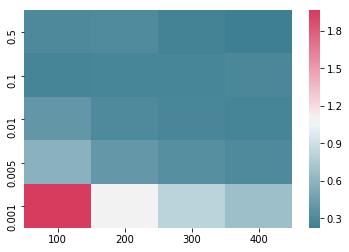

Y0.R.0 test
            100       200       300       400
0.5    0.898548  0.895084  0.913181  0.921363
0.1    0.915242  0.912231  0.911429  0.907759
0.01   0.744709  0.882023  0.906594  0.914576
0.005  0.499435  0.742956  0.840398  0.882844
0.001  0.051464  0.196421  0.316543  0.415441


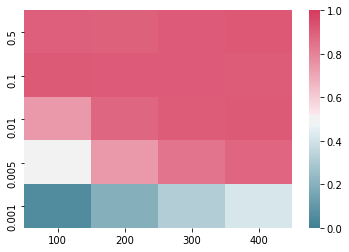

Y0.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860797  0.980367  0.997218  0.999600
0.005  0.626471  0.860108  0.947434  0.980204
0.001  0.178884  0.325454  0.445797  0.544729


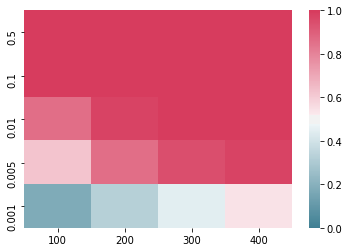

Y0.R.0 bcstd
            100       200       300       400
0.5    0.056873  0.060063  0.050889  0.040533
0.1    0.050911  0.053772  0.052785  0.055659
0.01   0.070062  0.059165  0.055144  0.052675
0.005  0.081463  0.070808  0.063487  0.058768
0.001  0.095868  0.091684  0.087923  0.084638


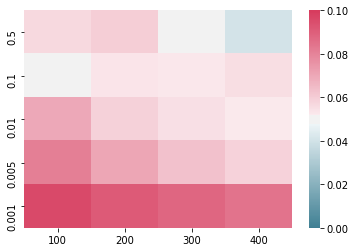

Y0.R.1 variance
            100       200       300       400
0.5    0.236170  0.264048  0.233938  0.262401
0.1    0.228466  0.232634  0.240089  0.244899
0.01   0.386487  0.289983  0.253032  0.243404
0.005  0.562914  0.388313  0.320510  0.289610
0.001  1.956022  1.091543  0.800917  0.654480


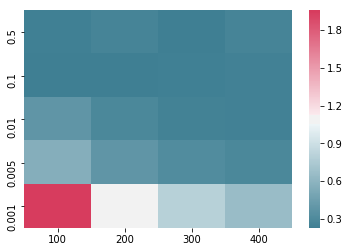

Y0.R.1 test
            100       200       300       400
0.5    0.917448  0.908143  0.916795  0.909028
0.1    0.924454  0.922891  0.920714  0.919167
0.01   0.747347  0.885690  0.913759  0.919459
0.005  0.503198  0.746241  0.845272  0.885700
0.001  0.052058  0.198152  0.318668  0.418653


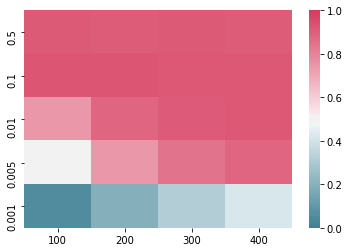

Y0.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860844  0.980368  0.997216  0.999600
0.005  0.626666  0.860091  0.947486  0.980219
0.001  0.178793  0.325608  0.445844  0.544665


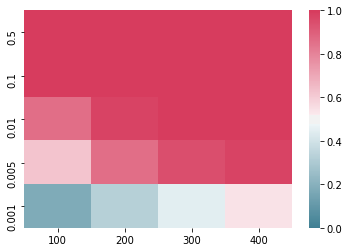

Y0.R.1 bcstd
            100       200       300       400
0.5    0.049213  0.056246  0.045598  0.051723
0.1    0.047419  0.047972  0.047624  0.049014
0.01   0.068829  0.057203  0.050872  0.049354
0.005  0.080542  0.069388  0.061452  0.057044
0.001  0.095774  0.091332  0.087285  0.083600


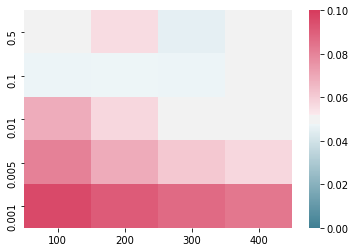

Y0.I.0 variance
            100       200       300       400
0.5    0.552871  0.834449  0.419962  0.642227
0.1    0.517695  0.548275  0.578372  0.577748
0.01   0.501893  0.534578  0.580252  0.579614
0.005  0.448272  0.490294  0.534873  0.562079
0.001  0.675211  0.511243  0.462375  0.449749


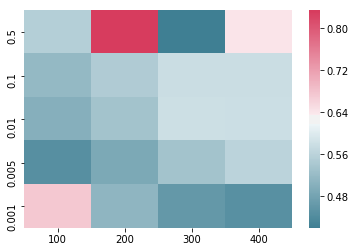

Y0.I.0 test
            100       200       300       400
0.5    0.769061  0.668883  0.811118  0.731810
0.1    0.790857  0.783090  0.773691  0.773876
0.01   0.653966  0.754100  0.763441  0.770150
0.005  0.474332  0.656604  0.720848  0.745542
0.001  0.111727  0.231228  0.329778  0.408952


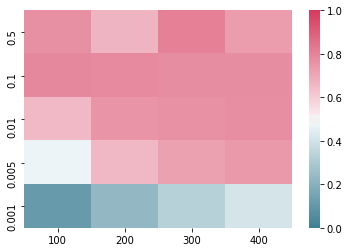

Y0.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999922  0.999998  1.000000  1.000000
0.01   0.832529  0.967666  0.992558  0.997658
0.005  0.596716  0.831678  0.927639  0.967772
0.001  0.168275  0.306914  0.421822  0.516850


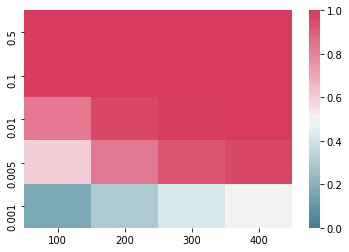

Y0.I.0 bcstd
            100       200       300       400
0.5    0.090369  0.112950  0.076167  0.097209
0.1    0.090646  0.092546  0.095068  0.096349
0.01   0.082662  0.089896  0.095097  0.095578
0.005  0.069870  0.082281  0.088735  0.092223
0.001  0.052692  0.057857  0.061838  0.065551


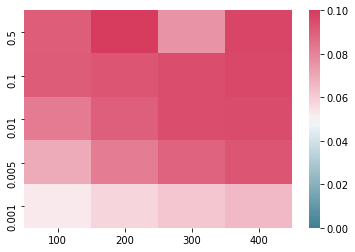

Y0.I.1 variance
            100       200       300       400
0.5    0.322653  0.238478  0.279988  0.263073
0.1    0.358860  0.310942  0.329224  0.341689
0.01   0.502129  0.426153  0.398472  0.382628
0.005  0.660628  0.492472  0.448018  0.412943
0.001  1.924671  1.125575  0.858779  0.732664


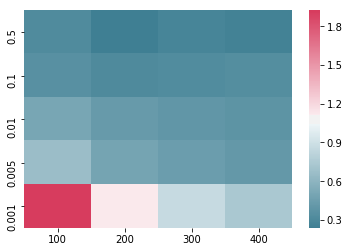

Y0.I.1 test
            100       200       300       400
0.5    0.827166  0.846992  0.831249  0.853663
0.1    0.838991  0.855686  0.848755  0.845191
0.01   0.668459  0.794293  0.820994  0.830722
0.005  0.448758  0.670168  0.757032  0.797452
0.001  0.053414  0.183217  0.290352  0.378267


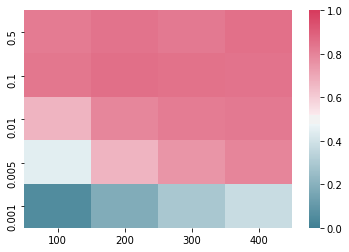

Y0.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999828  0.999996  1.000000  1.000000
0.01   0.832873  0.964594  0.989849  0.996235
0.005  0.599296  0.832521  0.925847  0.964537
0.001  0.169850  0.309618  0.424969  0.520444


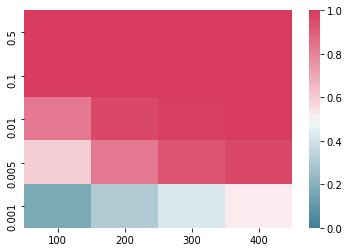

Y0.I.1 bcstd
            100       200       300       400
0.5    0.059629  0.041144  0.041835  0.042730
0.1    0.062841  0.056529  0.059362  0.059671
0.01   0.075192  0.068667  0.065798  0.065299
0.005  0.081455  0.074735  0.071615  0.067689
0.001  0.088773  0.086663  0.084823  0.083585


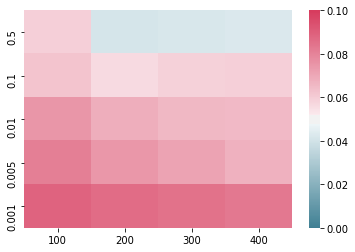

Y1.R.0 variance
            100       200       300       400
0.5    0.210576  0.289197  0.214326  0.213962
0.1    0.235939  0.250681  0.251371  0.239843
0.01   0.404474  0.297308  0.262530  0.257755
0.005  0.590856  0.398087  0.333160  0.304787
0.001  1.966196  1.102991  0.812085  0.667648


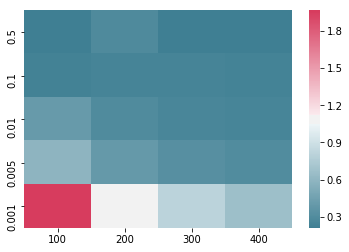

Y1.R.0 test
            100       200       300       400
0.5    0.926372  0.900340  0.923857  0.924968
0.1    0.922104  0.917324  0.917116  0.920655
0.01   0.742888  0.883869  0.910971  0.915026
0.005  0.497424  0.743677  0.842036  0.881090
0.001  0.051519  0.196599  0.317033  0.416333


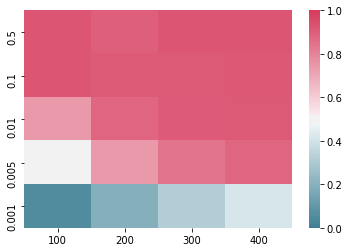

Y1.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860819  0.980398  0.997212  0.999601
0.005  0.626654  0.859965  0.947433  0.980179
0.001  0.178782  0.325464  0.445803  0.544709


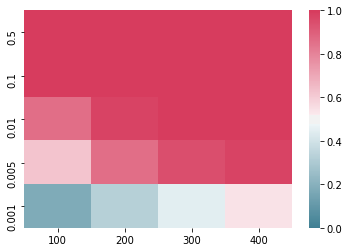

Y1.R.0 bcstd
            100       200       300       400
0.5    0.043046  0.061415  0.048447  0.044003
0.1    0.049258  0.050931  0.051335  0.049276
0.01   0.071553  0.059206  0.053587  0.052428
0.005  0.082493  0.070740  0.064104  0.059663
0.001  0.095954  0.091784  0.087947  0.084568


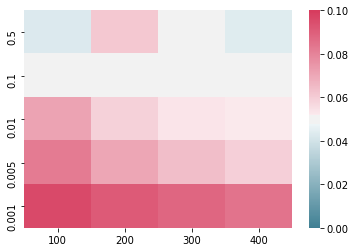

Y1.R.1 variance
            100       200       300       400
0.5    0.256235  0.248157  0.264591  0.214593
0.1    0.219757  0.248993  0.228055  0.234228
0.01   0.385284  0.287574  0.254552  0.236057
0.005  0.565442  0.383010  0.321576  0.286320
0.001  1.947425  1.088465  0.799378  0.653699


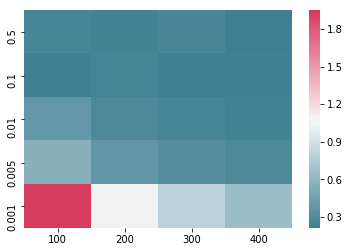

Y1.R.1 test
            100       200       300       400
0.5    0.911870  0.914326  0.908821  0.925061
0.1    0.926899  0.917980  0.924462  0.922385
0.01   0.747874  0.886649  0.913444  0.921822
0.005  0.502352  0.747585  0.845057  0.886711
0.001  0.052413  0.197989  0.318875  0.418961


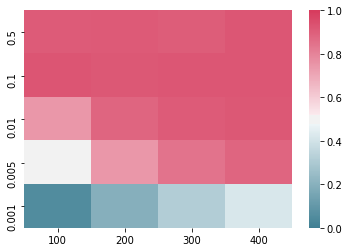

Y1.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860729  0.980432  0.997210  0.999600
0.005  0.626377  0.860057  0.947440  0.980216
0.001  0.178860  0.325539  0.445838  0.544590


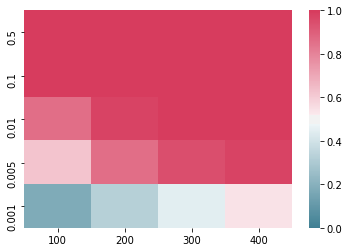

Y1.R.1 bcstd
            100       200       300       400
0.5    0.049952  0.052860  0.049768  0.044832
0.1    0.045969  0.051006  0.047924  0.050005
0.01   0.069098  0.057430  0.052514  0.049068
0.005  0.080660  0.068988  0.062095  0.057269
0.001  0.095747  0.091316  0.087350  0.083966


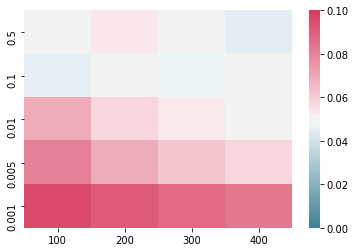

Y1.I.0 variance
            100       200       300       400
0.5    0.494509  0.575492  0.545300  0.540281
0.1    0.425357  0.482036  0.420141  0.450535
0.01   0.243322  0.356286  0.418663  0.420242
0.005  0.165244  0.238775  0.301662  0.358424
0.001  0.119739  0.129121  0.139088  0.151464


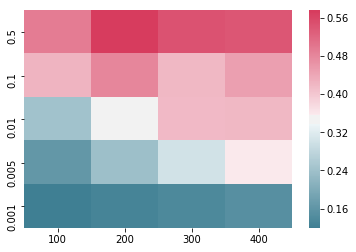

Y1.I.0 test
            100       200       300       400
0.5    0.797654  0.770697  0.786493  0.775623
0.1    0.832711  0.815527  0.834195  0.824820
0.01   0.745052  0.828666  0.829329  0.832999
0.005  0.549635  0.745817  0.811535  0.827963
0.001  0.153785  0.284015  0.391331  0.477686


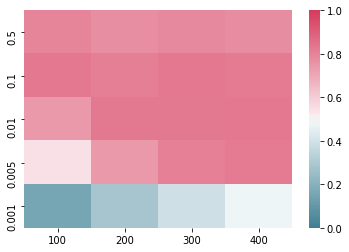

Y1.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999932  0.999998  1.000000  1.000000
0.01   0.846721  0.973620  0.994269  0.998200
0.005  0.611608  0.845715  0.937255  0.973392
0.001  0.173584  0.316187  0.433912  0.530752


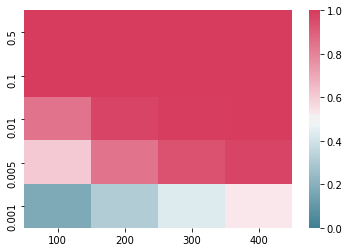

Y1.I.0 bcstd
            100       200       300       400
0.5    0.104902  0.105293  0.105139  0.106582
0.1    0.091093  0.097578  0.091718  0.095312
0.01   0.067002  0.086943  0.094103  0.093905
0.005  0.045692  0.065738  0.079424  0.087486
0.001  0.020223  0.028451  0.034731  0.040259


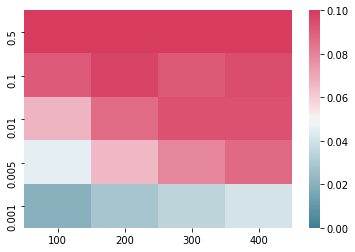

Y1.I.1 variance
            100       200       300       400
0.5    0.190526  0.247186  0.242771  0.247291
0.1    0.247836  0.232470  0.203497  0.230615
0.01   0.345748  0.271754  0.250391  0.242397
0.005  0.513687  0.354984  0.300500  0.271763
0.001  1.732274  0.979200  0.721163  0.593197


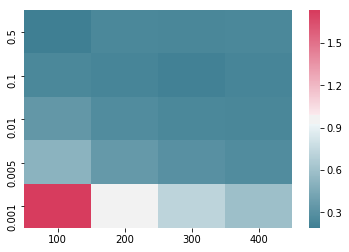

Y1.I.1 test
            100       200       300       400
0.5    0.866334  0.831566  0.850481  0.835721
0.1    0.867295  0.870923  0.875812  0.870489
0.01   0.692343  0.827318  0.856874  0.866495
0.005  0.462515  0.688314  0.783733  0.827360
0.001  0.059391  0.189083  0.296866  0.386356


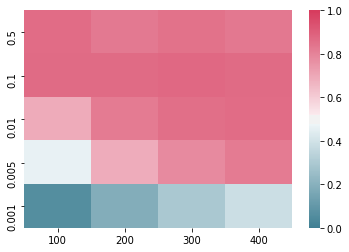

Y1.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999823  0.999995  1.000000  1.000000
0.01   0.827677  0.963463  0.989702  0.996201
0.005  0.592339  0.826640  0.922333  0.963261
0.001  0.167370  0.305008  0.419098  0.513388


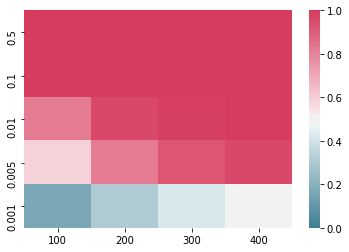

Y1.I.1 bcstd
            100       200       300       400
0.5    0.041627  0.056365  0.048994  0.051096
0.1    0.056191  0.049097  0.046705  0.054261
0.01   0.064841  0.058133  0.056023  0.053325
0.005  0.074000  0.066353  0.060625  0.056777
0.001  0.083870  0.080621  0.077774  0.075904


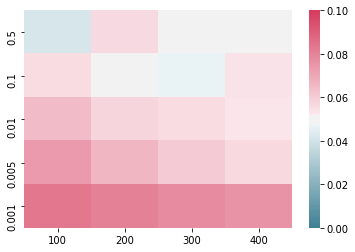

Y2.R.0 variance
            100       200       300       400
0.5    0.277742  0.240660  0.244002  0.294554
0.1    0.266352  0.252587  0.236730  0.253597
0.01   0.399914  0.301093  0.269164  0.259206
0.005  0.585537  0.402184  0.332279  0.302952
0.001  1.969997  1.106071  0.816068  0.670849


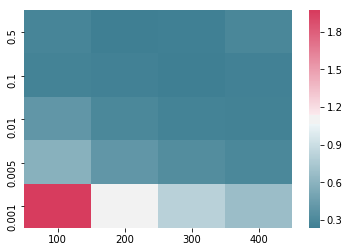

Y2.R.0 test
            100       200       300       400
0.5    0.902232  0.916314  0.914020  0.897109
0.1    0.912537  0.916756  0.921704  0.916304
0.01   0.743294  0.882357  0.908979  0.914488
0.005  0.497871  0.742481  0.842233  0.881846
0.001  0.051029  0.196326  0.316390  0.415802


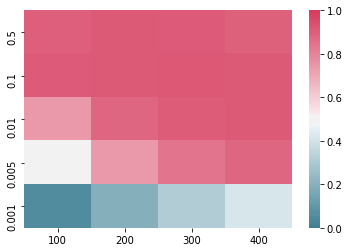

Y2.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860480  0.980382  0.997210  0.999603
0.005  0.626495  0.859904  0.947427  0.980223
0.001  0.178786  0.325350  0.445816  0.544662


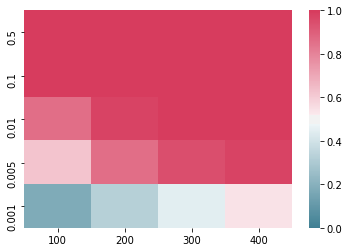

Y2.R.0 bcstd
            100       200       300       400
0.5    0.054478  0.051051  0.048785  0.057641
0.1    0.055021  0.052151  0.049730  0.051792
0.01   0.070530  0.059342  0.055485  0.053158
0.005  0.082014  0.071146  0.064032  0.059995
0.001  0.096008  0.091842  0.088031  0.084807


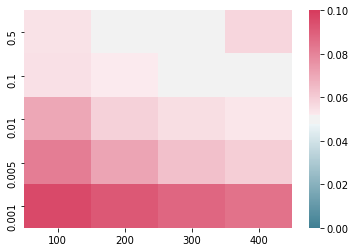

Y2.R.1 variance
            100       200       300       400
0.5    0.280008  0.294773  0.231446  0.216268
0.1    0.229907  0.237368  0.228538  0.222733
0.01   0.381754  0.284087  0.249778  0.234512
0.005  0.566216  0.382830  0.317052  0.286026
0.001  1.952471  1.092927  0.801725  0.653646


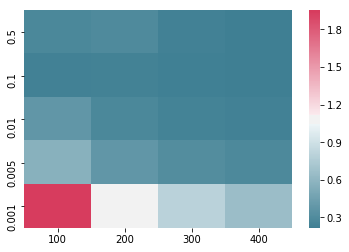

Y2.R.1 test
            100       200       300       400
0.5    0.903779  0.898341  0.914776  0.923365
0.1    0.923703  0.921503  0.923870  0.925763
0.01   0.748685  0.887599  0.914847  0.922314
0.005  0.502246  0.747664  0.846744  0.886861
0.001  0.052058  0.197356  0.318290  0.418851


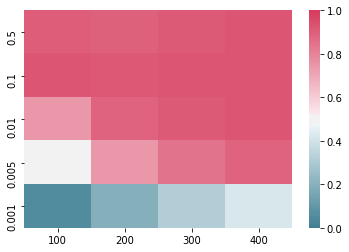

Y2.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860643  0.980412  0.997205  0.999598
0.005  0.626446  0.859962  0.947382  0.980201
0.001  0.178890  0.325373  0.445797  0.544521


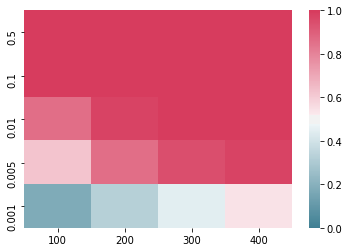

Y2.R.1 bcstd
            100       200       300       400
0.5    0.052492  0.055602  0.043382  0.046131
0.1    0.048660  0.049841  0.047711  0.047002
0.01   0.069195  0.056931  0.051269  0.049011
0.005  0.080618  0.068947  0.061720  0.057546
0.001  0.095731  0.091375  0.087499  0.083785


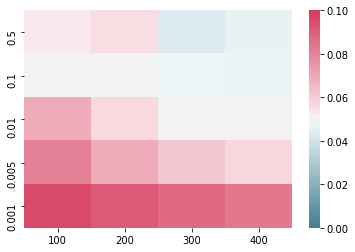

Y2.I.0 variance
            100       200       300       400
0.5    0.480366  0.373414  0.360673  0.495478
0.1    0.408995  0.434653  0.428115  0.367440
0.01   0.210033  0.326364  0.375465  0.403277
0.005  0.145374  0.206771  0.287989  0.334609
0.001  0.093141  0.104431  0.113340  0.134319


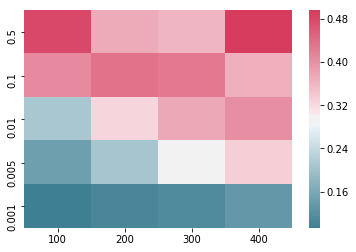

Y2.I.0 test
            100       200       300       400
0.5    0.810876  0.836777  0.842365  0.800007
0.1    0.840909  0.832016  0.834476  0.854085
0.01   0.756817  0.839835  0.844966  0.840255
0.005  0.555169  0.758142  0.818494  0.837361
0.001  0.156642  0.288455  0.396665  0.482979


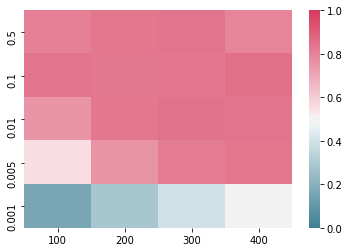

Y2.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999931  0.999998  1.000000  1.000000
0.01   0.847023  0.973882  0.994401  0.998211
0.005  0.612129  0.846748  0.937859  0.973803
0.001  0.173710  0.316544  0.434294  0.531177


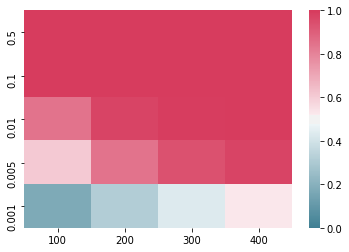

Y2.I.0 bcstd
            100       200       300       400
0.5    0.104710  0.087657  0.083406  0.099276
0.1    0.091694  0.092821  0.095681  0.085916
0.01   0.061499  0.085505  0.090405  0.092114
0.005  0.042731  0.062262  0.078150  0.085241
0.001  0.016697  0.024559  0.030467  0.037768


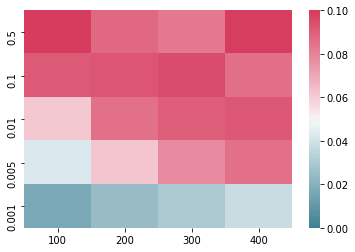

Y2.I.1 variance
            100       200       300       400
0.5    0.145820  0.182270  0.242065  0.208001
0.1    0.224063  0.207347  0.222440  0.231718
0.01   0.343821  0.260985  0.231554  0.229347
0.005  0.498694  0.335727  0.287015  0.259344
0.001  1.707333  0.954110  0.702350  0.575065


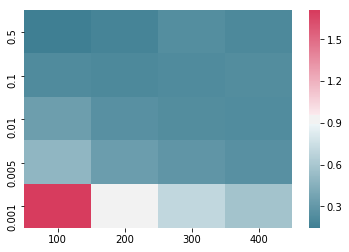

Y2.I.1 test
            100       200       300       400
0.5    0.862054  0.850986  0.824614  0.837519
0.1    0.865797  0.869318  0.864470  0.860532
0.01   0.679827  0.817951  0.850389  0.858910
0.005  0.456098  0.682517  0.774428  0.818079
0.001  0.058845  0.187538  0.293375  0.381659


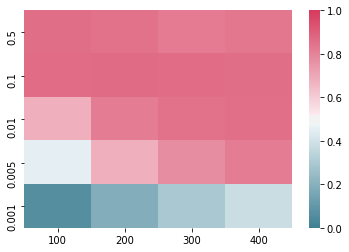

Y2.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999791  0.999995  1.000000  1.000000
0.01   0.825683  0.963031  0.989498  0.995852
0.005  0.590665  0.825157  0.921199  0.962634
0.001  0.166051  0.303696  0.416949  0.511637


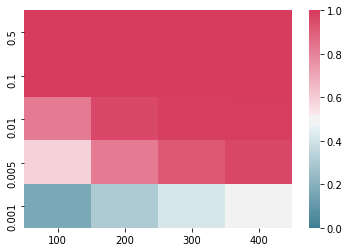

Y2.I.1 bcstd
            100       200       300       400
0.5    0.026949  0.045830  0.054793  0.035565
0.1    0.055937  0.048254  0.052023  0.053505
0.01   0.065626  0.056110  0.053314  0.051745
0.005  0.071484  0.063735  0.058155  0.055645
0.001  0.082912  0.079606  0.076376  0.074194


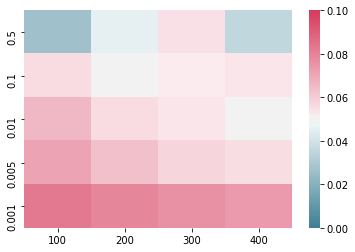

Y3.R.0 variance
            100       200       300       400
0.5    0.246996  0.219830  0.237479  0.219581
0.1    0.254885  0.227106  0.251858  0.238469
0.01   0.395874  0.293125  0.265382  0.252856
0.005  0.570381  0.396967  0.326629  0.297342
0.001  1.957313  1.098366  0.808957  0.660098


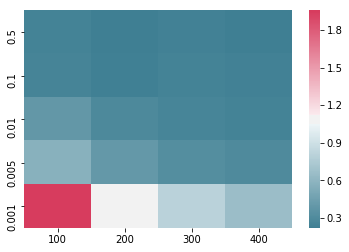

Y3.R.0 test
            100       200       300       400
0.5    0.914374  0.923325  0.916911  0.921630
0.1    0.915751  0.924704  0.916659  0.921078
0.01   0.744763  0.884857  0.909931  0.916400
0.005  0.500964  0.743988  0.843694  0.883475
0.001  0.051712  0.196954  0.317233  0.417029


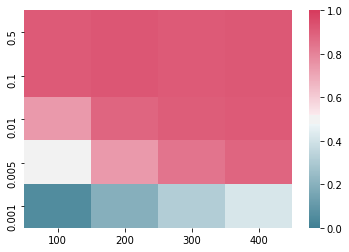

Y3.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860906  0.980399  0.997212  0.999600
0.005  0.626286  0.860203  0.947430  0.980208
0.001  0.178747  0.325427  0.445807  0.544503


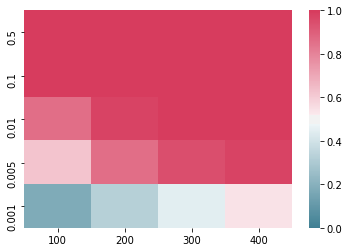

Y3.R.0 bcstd
            100       200       300       400
0.5    0.054438  0.050340  0.048331  0.046792
0.1    0.054300  0.049446  0.052150  0.051327
0.01   0.070844  0.057907  0.054440  0.052900
0.005  0.081184  0.070621  0.063170  0.059443
0.001  0.095738  0.091640  0.087913  0.084013


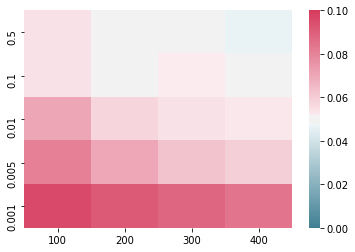

Y3.R.1 variance
            100       200       300       400
0.5    0.228491  0.213235  0.227826  0.220955
0.1    0.220356  0.218581  0.221024  0.220019
0.01   0.374312  0.275413  0.243357  0.230598
0.005  0.558745  0.378306  0.310939  0.275626
0.001  1.943998  1.079956  0.791691  0.644792


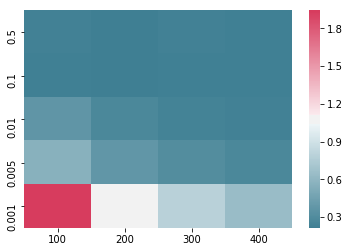

Y3.R.1 test
            100       200       300       400
0.5    0.919597  0.925195  0.920076  0.920076
0.1    0.926740  0.927190  0.926280  0.926687
0.01   0.750534  0.890190  0.916762  0.923443
0.005  0.503037  0.748566  0.848060  0.889866
0.001  0.052399  0.198404  0.319452  0.419680


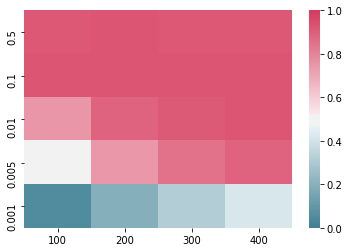

Y3.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860643  0.980410  0.997201  0.999599
0.005  0.626314  0.859876  0.947386  0.980165
0.001  0.178836  0.325416  0.445777  0.544526


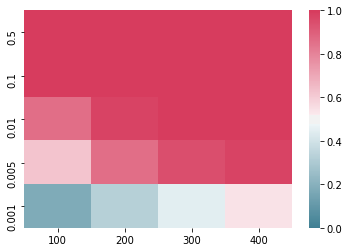

Y3.R.1 bcstd
            100       200       300       400
0.5    0.050133  0.042414  0.046150  0.042399
0.1    0.047005  0.046397  0.046332  0.046223
0.01   0.067988  0.056169  0.050757  0.048393
0.005  0.080090  0.068407  0.060591  0.055221
0.001  0.095619  0.091022  0.087003  0.083212


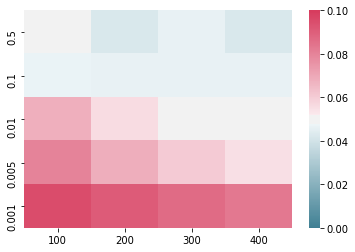

Y3.I.0 variance
            100       200       300       400
0.5    0.357947  0.485437  0.528516  0.341059
0.1    0.446078  0.393885  0.423716  0.446017
0.01   0.213287  0.308891  0.377595  0.409640
0.005  0.140066  0.209389  0.290680  0.327095
0.001  0.090660  0.103736  0.119403  0.130142


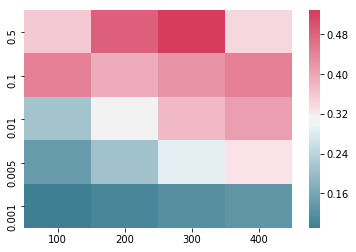

Y3.I.0 test
            100       200       300       400
0.5    0.841332  0.807520  0.793026  0.852180
0.1    0.829385  0.844793  0.836543  0.828036
0.01   0.758253  0.846531  0.844502  0.839255
0.005  0.557498  0.758064  0.818258  0.840421
0.001  0.156598  0.288025  0.395721  0.484321


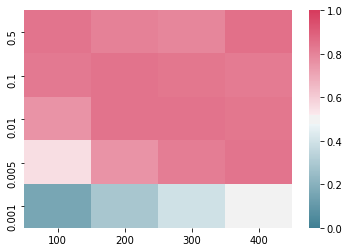

Y3.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999927  0.999998  1.000000  1.000000
0.01   0.847621  0.974035  0.994291  0.998163
0.005  0.612185  0.846933  0.937957  0.973801
0.001  0.173610  0.316466  0.434390  0.531498


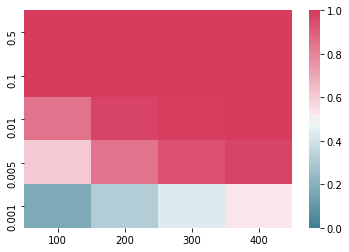

Y3.I.0 bcstd
            100       200       300       400
0.5    0.085960  0.108962  0.103860  0.088920
0.1    0.095210  0.089625  0.094428  0.095716
0.01   0.062570  0.082467  0.090223  0.093922
0.005  0.041385  0.062576  0.077647  0.083599
0.001  0.016368  0.024620  0.031429  0.036874


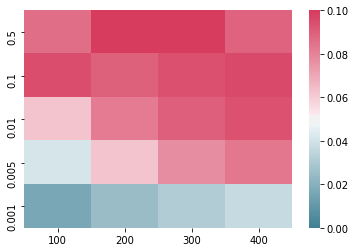

Y3.I.1 variance
            100       200       300       400
0.5    0.188677  0.241553  0.186885  0.048672
0.1    0.229200  0.263800  0.227165  0.239913
0.01   0.349962  0.270017  0.255356  0.243980
0.005  0.513933  0.354289  0.305706  0.277229
0.001  1.734650  0.976958  0.720313  0.592327


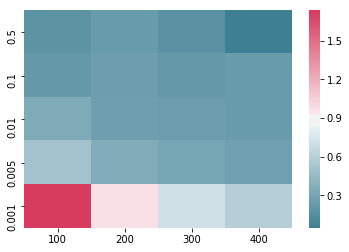

Y3.I.1 test
            100       200       300       400
0.5    0.836966  0.827573  0.833056  0.889611
0.1    0.855845  0.843354  0.854254  0.854120
0.01   0.677189  0.812058  0.835792  0.845297
0.005  0.457449  0.675450  0.767270  0.808355
0.001  0.058394  0.186510  0.293522  0.382099


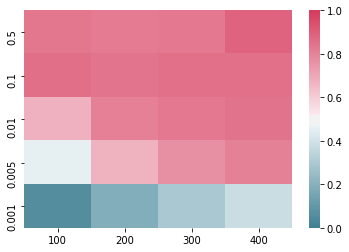

Y3.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999752  0.999995  1.000000  1.000000
0.01   0.825626  0.961707  0.988555  0.995340
0.005  0.591639  0.824270  0.920644  0.961482
0.001  0.167026  0.304754  0.418434  0.512934


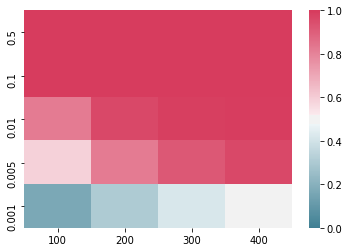

Y3.I.1 bcstd
            100       200       300       400
0.5    0.045885  0.040717  0.046494  0.002290
0.1    0.050995  0.051873  0.049435  0.048577
0.01   0.062130  0.051347  0.051080  0.049911
0.005  0.071503  0.062657  0.057741  0.053047
0.001  0.083596  0.079706  0.076628  0.073625


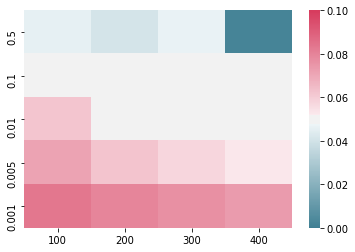

Y4.R.0 variance
            100       200       300       400
0.5    0.232768  0.261727  0.230354  0.267184
0.1    0.260609  0.256384  0.235355  0.276650
0.01   0.393907  0.298580  0.268321  0.258086
0.005  0.581645  0.398992  0.335664  0.301053
0.001  1.962223  1.094748  0.809367  0.665966


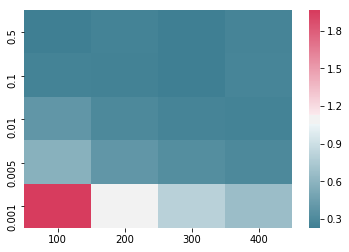

Y4.R.0 test
            100       200       300       400
0.5    0.917677  0.908652  0.917881  0.907480
0.1    0.914033  0.915415  0.922092  0.908813
0.01   0.745464  0.883130  0.909093  0.914735
0.005  0.498734  0.743431  0.840955  0.882230
0.001  0.051735  0.197571  0.317470  0.416371


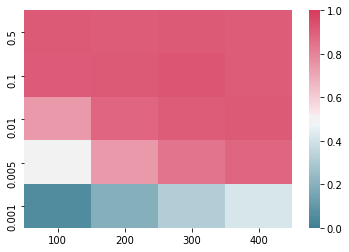

Y4.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860781  0.980397  0.997214  0.999600
0.005  0.626526  0.859961  0.947393  0.980218
0.001  0.178741  0.325535  0.445698  0.544615


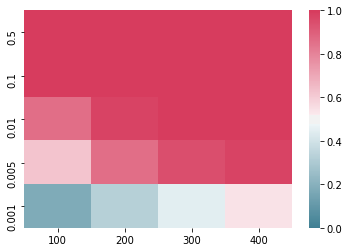

Y4.R.0 bcstd
            100       200       300       400
0.5    0.048548  0.051628  0.050977  0.053120
0.1    0.052891  0.052547  0.049001  0.055247
0.01   0.070234  0.059032  0.054346  0.052909
0.005  0.081662  0.070656  0.063736  0.059213
0.001  0.095834  0.091394  0.087625  0.084213


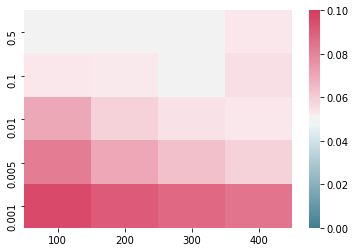

Y4.R.1 variance
            100       200       300       400
0.5    0.218755  0.242499  0.215353  0.241440
0.1    0.233475  0.229904  0.229691  0.229971
0.01   0.385555  0.284574  0.252004  0.238290
0.005  0.561477  0.381247  0.320290  0.283813
0.001  1.942704  1.084037  0.794328  0.651146


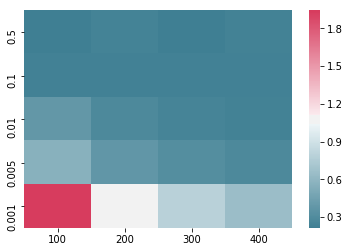

Y4.R.1 test
            100       200       300       400
0.5    0.924304  0.914628  0.923524  0.915749
0.1    0.922497  0.923161  0.923414  0.923590
0.01   0.747316  0.887091  0.914053  0.920711
0.005  0.502625  0.748340  0.845070  0.887238
0.001  0.052365  0.198492  0.319121  0.418865


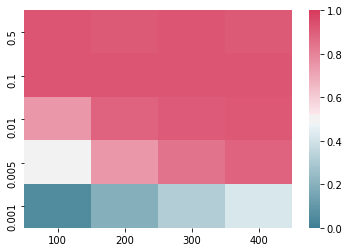

Y4.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860564  0.980358  0.997209  0.999597
0.005  0.626511  0.860004  0.947369  0.980194
0.001  0.178818  0.325456  0.445920  0.544550


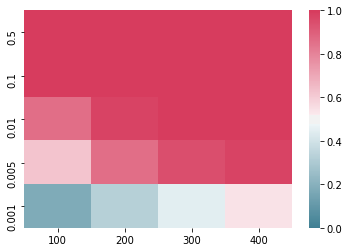

Y4.R.1 bcstd
            100       200       300       400
0.5    0.048322  0.050539  0.043333  0.048418
0.1    0.047858  0.048404  0.048769  0.048626
0.01   0.069237  0.056097  0.051818  0.048829
0.005  0.079999  0.068207  0.061068  0.056116
0.001  0.095512  0.091076  0.086876  0.083547


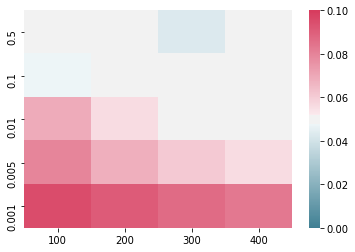

Y4.I.0 variance
            100       200       300       400
0.5    0.515599  0.549698  0.454401  0.387457
0.1    0.481889  0.455420  0.414715  0.392185
0.01   0.225744  0.342077  0.392263  0.413849
0.005  0.151913  0.226449  0.286991  0.340273
0.001  0.095158  0.113081  0.125323  0.140998


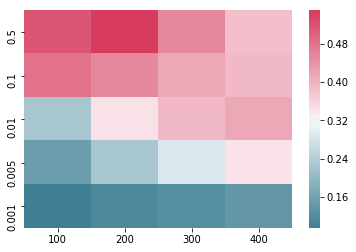

Y4.I.0 test
            100       200       300       400
0.5    0.791121  0.786300  0.815673  0.834434
0.1    0.819211  0.828993  0.840255  0.847743
0.01   0.755176  0.837420  0.842198  0.839267
0.005  0.555537  0.754647  0.821255  0.838478
0.001  0.156667  0.288244  0.395950  0.482955


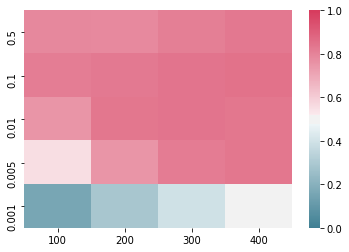

Y4.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999915  0.999997  1.000000  1.000000
0.01   0.847317  0.973625  0.994129  0.997998
0.005  0.612009  0.846428  0.937560  0.973504
0.001  0.173535  0.316466  0.434086  0.530970


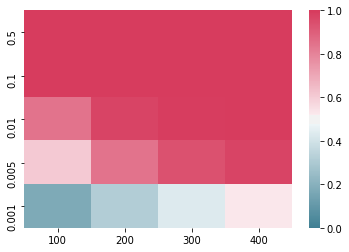

Y4.I.0 bcstd
            100       200       300       400
0.5    0.102834  0.103449  0.096906  0.082518
0.1    0.101345  0.098522  0.091983  0.093403
0.01   0.064546  0.085191  0.092241  0.093787
0.005  0.043224  0.064188  0.076422  0.085252
0.001  0.016624  0.025367  0.032216  0.038631


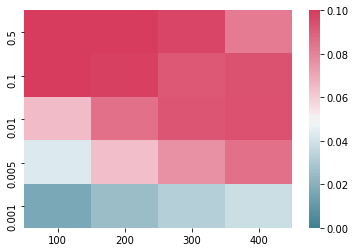

Y4.I.1 variance
            100       200       300       400
0.5    0.209044  0.112100  0.102630  0.048644
0.1    0.227556  0.177880  0.244812  0.263443
0.01   0.401375  0.292043  0.247748  0.234107
0.005  0.573615  0.411605  0.330747  0.285436
0.001  1.770980  1.017181  0.768667  0.644664


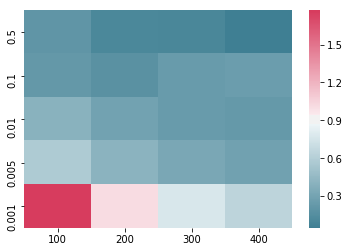

Y4.I.1 test
            100       200       300       400
0.5    0.844051  0.878580  0.869510  0.888630
0.1    0.859781  0.874536  0.851830  0.848646
0.01   0.668296  0.807787  0.842807  0.852658
0.005  0.448231  0.664737  0.764445  0.809938
0.001  0.057397  0.184620  0.289001  0.375814


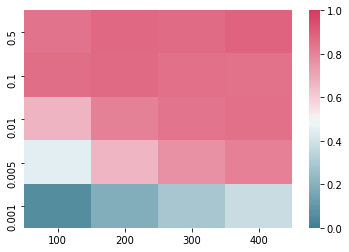

Y4.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999741  0.999994  1.000000  1.000000
0.01   0.828465  0.962308  0.988558  0.995172
0.005  0.595132  0.827311  0.923000  0.962442
0.001  0.167790  0.306266  0.420518  0.515582


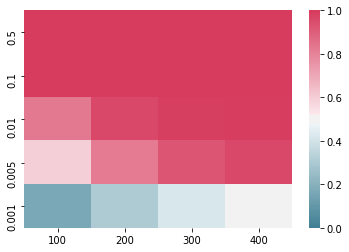

Y4.I.1 bcstd
            100       200       300       400
0.5    0.051599  0.015171  0.020592  0.007243
0.1    0.050677  0.039791  0.047614  0.054361
0.01   0.065426  0.053579  0.048470  0.047166
0.005  0.075859  0.068237  0.059433  0.053801
0.001  0.084890  0.082195  0.079978  0.078404


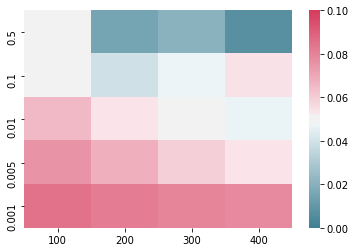

Y5.R.0 variance
            100       200       300       400
0.5    0.276637  0.258895  0.215291  0.245754
0.1    0.264538  0.239132  0.247395  0.259952
0.01   0.396837  0.304326  0.271355  0.257825
0.005  0.580666  0.400495  0.333131  0.294855
0.001  1.957838  1.095478  0.809208  0.671908


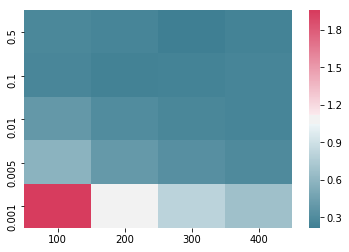

Y5.R.0 test
            100       200       300       400
0.5    0.903649  0.910403  0.923068  0.914238
0.1    0.912895  0.920752  0.918061  0.914147
0.01   0.744420  0.881205  0.908086  0.914945
0.005  0.498344  0.742867  0.841845  0.884099
0.001  0.051739  0.197346  0.317102  0.415494


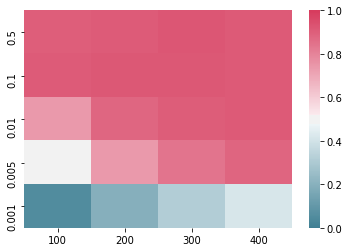

Y5.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860721  0.980401  0.997213  0.999599
0.005  0.626486  0.860162  0.947438  0.980210
0.001  0.178757  0.325426  0.445633  0.544639


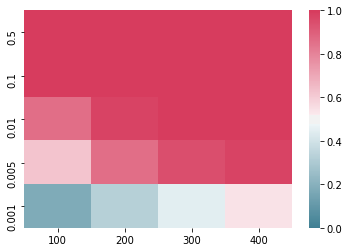

Y5.R.0 bcstd
            100       200       300       400
0.5    0.055627  0.052026  0.048364  0.048618
0.1    0.054224  0.047704  0.049973  0.052169
0.01   0.070112  0.059466  0.054568  0.053029
0.005  0.080921  0.070633  0.063564  0.058163
0.001  0.095700  0.091417  0.087605  0.084617


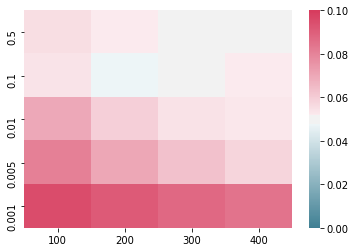

Y5.R.1 variance
            100       200       300       400
0.5    0.225640  0.225787  0.225608  0.226817
0.1    0.232612  0.225507  0.227093  0.226899
0.01   0.383236  0.284688  0.253111  0.234354
0.005  0.560965  0.378452  0.318658  0.281605
0.001  1.940126  1.079906  0.791982  0.650392


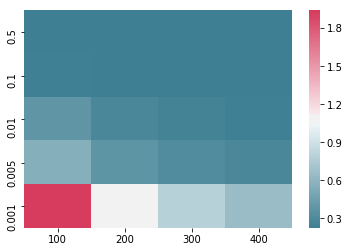

Y5.R.1 test
            100       200       300       400
0.5    0.919255  0.919816  0.921484  0.918287
0.1    0.922678  0.924905  0.924403  0.924632
0.01   0.747864  0.887283  0.913605  0.922132
0.005  0.502353  0.748289  0.845660  0.887833
0.001  0.052610  0.198499  0.319365  0.418948


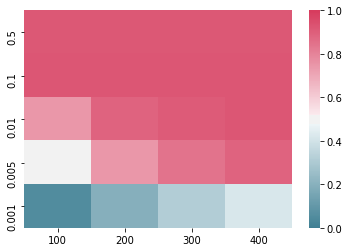

Y5.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860651  0.980364  0.997213  0.999600
0.005  0.626389  0.859893  0.947384  0.980175
0.001  0.178857  0.325453  0.445796  0.544607


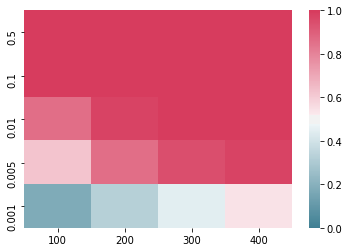

Y5.R.1 bcstd
            100       200       300       400
0.5    0.056207  0.044475  0.051869  0.046597
0.1    0.045556  0.046915  0.046434  0.044676
0.01   0.068000  0.055978  0.051061  0.048263
0.005  0.079784  0.067963  0.060680  0.055632
0.001  0.095422  0.090839  0.086705  0.083283


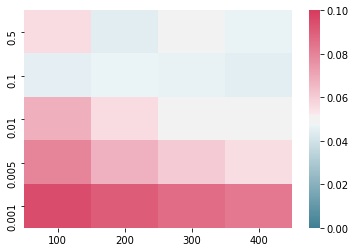

Y5.I.0 variance
            100       200       300       400
0.5    0.365872  0.214251  0.317043  0.157335
0.1    0.282026  0.268416  0.260624  0.238863
0.01   0.111434  0.219845  0.265708  0.294993
0.005  0.054168  0.114166  0.168589  0.208782
0.001  0.039229  0.029638  0.033326  0.040473


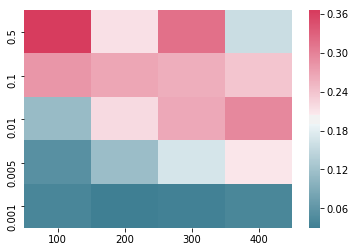

Y5.I.0 test
            100       200       300       400
0.5    0.848768  0.895009  0.860245  0.918057
0.1    0.885398  0.889926  0.893588  0.900891
0.01   0.786504  0.877535  0.885087  0.880625
0.005  0.577643  0.785609  0.856788  0.880501
0.001  0.163042  0.300665  0.412327  0.503315


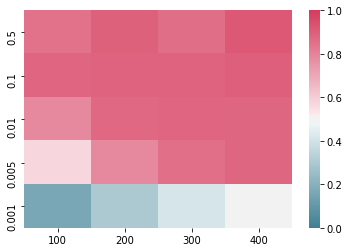

Y5.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999944  0.999999  1.000000  1.000000
0.01   0.849645  0.974706  0.994591  0.998264
0.005  0.615231  0.849260  0.939325  0.974558
0.001  0.174927  0.318700  0.436922  0.534373


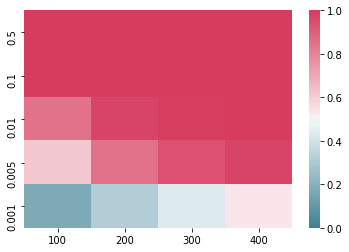

Y5.I.0 bcstd
            100       200       300       400
0.5    0.095894  0.087354  0.086637  0.068663
0.1    0.086269  0.084614  0.081769  0.079578
0.01   0.052750  0.076219  0.082565  0.085578
0.005  0.030966  0.053470  0.067376  0.074594
0.001  0.001071  0.008363  0.016984  0.024164


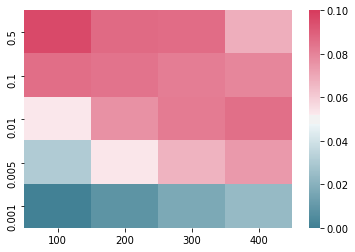

Y5.I.1 variance
            100       200       300       400
0.5    0.158950  0.141842  0.162753  0.169171
0.1    0.126553  0.157866  0.146292  0.133379
0.01   0.254604  0.176598  0.161624  0.154250
0.005  0.404413  0.253601  0.202533  0.185492
0.001  1.591566  0.855901  0.606434  0.482600


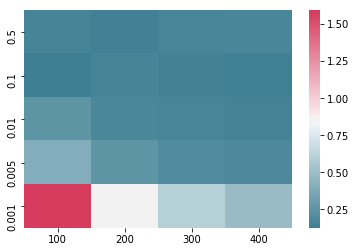

Y5.I.1 test
            100       200       300       400
0.5    0.843267  0.846146  0.845124  0.827804
0.1    0.884728  0.875918  0.878727  0.878719
0.01   0.694901  0.834811  0.863284  0.871865
0.005  0.468625  0.694291  0.790906  0.832189
0.001  0.063284  0.192965  0.301736  0.392116


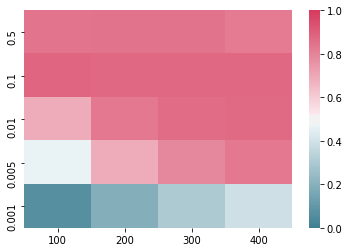

Y5.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999735  0.999993  1.000000  1.000000
0.01   0.823588  0.961165  0.988349  0.995135
0.005  0.589375  0.822262  0.919125  0.960981
0.001  0.165361  0.302076  0.415487  0.509891


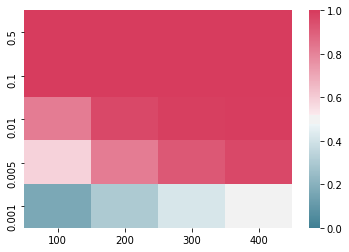

Y5.I.1 bcstd
            100       200       300       400
0.5    0.043180  0.033339  0.024564  0.038810
0.1    0.027369  0.035465  0.032370  0.032974
0.01   0.048799  0.034485  0.033722  0.031786
0.005  0.063673  0.049807  0.039390  0.036961
0.001  0.080388  0.075403  0.071151  0.067317


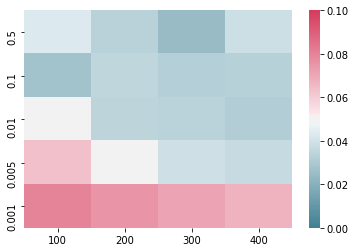

Y6.R.0 variance
            100       200       300       400
0.5    0.224983  0.225509  0.216673  0.216852
0.1    0.231331  0.225175  0.221371  0.230714
0.01   0.379817  0.280502  0.254019  0.235238
0.005  0.558984  0.381155  0.318426  0.283140
0.001  1.940917  1.079188  0.792417  0.647270


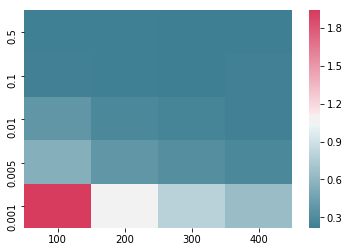

Y6.R.0 test
            100       200       300       400
0.5    0.920417  0.920399  0.923717  0.922937
0.1    0.922584  0.925106  0.926205  0.922948
0.01   0.748480  0.888589  0.913203  0.921823
0.005  0.502927  0.747723  0.845820  0.887388
0.001  0.052404  0.198376  0.318867  0.419288


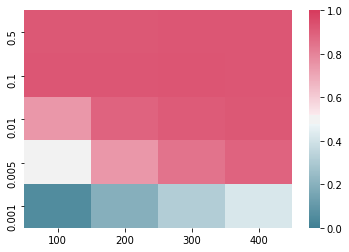

Y6.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860781  0.980372  0.997211  0.999598
0.005  0.626374  0.860013  0.947417  0.980198
0.001  0.178760  0.325441  0.445654  0.544616


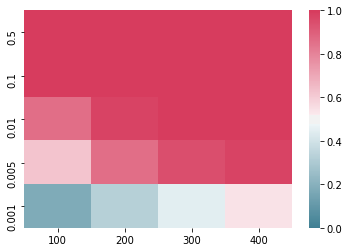

Y6.R.0 bcstd
            100       200       300       400
0.5    0.039907  0.045639  0.045076  0.041017
0.1    0.046122  0.046572  0.045138  0.046258
0.01   0.068198  0.055602  0.050687  0.048406
0.005  0.079921  0.068193  0.060819  0.055527
0.001  0.095400  0.090796  0.086968  0.083166


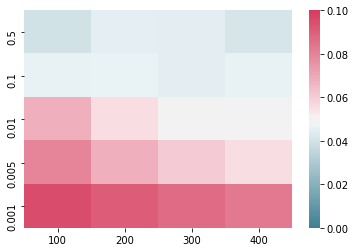

Y6.I.0 variance
            100       200       300       400
0.5    0.131604  0.164362  0.077925  0.103707
0.1    0.151976  0.137416  0.148977  0.144068
0.01   0.261492  0.178866  0.159866  0.156255
0.005  0.404836  0.255169  0.211987  0.188285
0.001  1.603222  0.854120  0.604814  0.479774


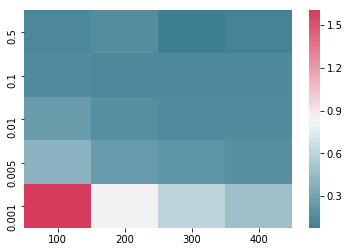

Y6.I.0 test
            100       200       300       400
0.5    0.842010  0.847012  0.874148  0.876549
0.1    0.882861  0.885143  0.882108  0.883956
0.01   0.695211  0.836701  0.867521  0.875447
0.005  0.469827  0.697173  0.792268  0.834284
0.001  0.063205  0.195722  0.303261  0.393690


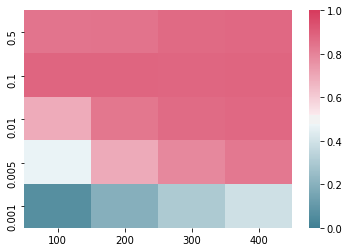

Y6.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999745  0.999994  1.000000  1.000000
0.01   0.823888  0.961035  0.988220  0.995131
0.005  0.589356  0.823033  0.919195  0.961021
0.001  0.165787  0.303338  0.416810  0.510492


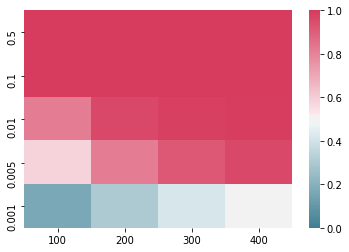

Y6.I.0 bcstd
            100       200       300       400
0.5    0.035496  0.029920  0.025959  0.030234
0.1    0.030103  0.033251  0.033287  0.030993
0.01   0.049572  0.035847  0.031961  0.033493
0.005  0.062685  0.048809  0.040587  0.036363
0.001  0.080508  0.075166  0.071282  0.067011


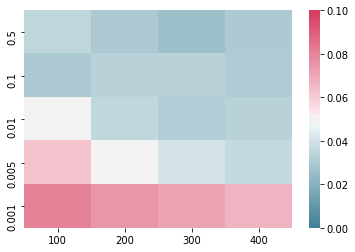

Y7.R.0 variance
            100       200       300       400
0.5    0.229623  0.220294  0.225508  0.217810
0.1    0.231571  0.237676  0.226053  0.232480
0.01   0.379124  0.278593  0.245337  0.237251
0.005  0.557716  0.378326  0.313669  0.281532
0.001  1.940859  1.077693  0.789173  0.646156


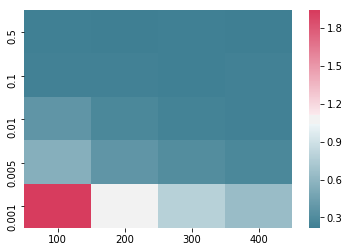

Y7.R.0 test
            100       200       300       400
0.5    0.918512  0.923655  0.920875  0.923241
0.1    0.923185  0.921038  0.924996  0.922430
0.01   0.748874  0.888933  0.916181  0.921246
0.005  0.502618  0.748401  0.846904  0.887915
0.001  0.052510  0.198805  0.319507  0.419210


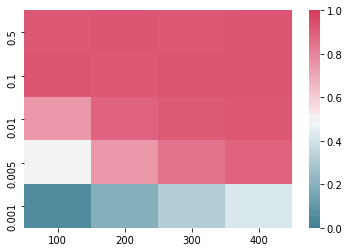

Y7.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860701  0.980333  0.997213  0.999598
0.005  0.626295  0.859887  0.947451  0.980182
0.001  0.178834  0.325340  0.445564  0.544579


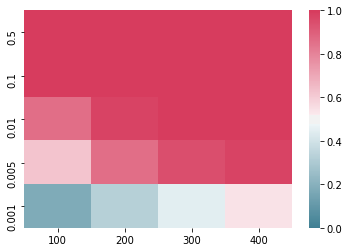

Y7.R.0 bcstd
            100       200       300       400
0.5    0.052819  0.050898  0.049401  0.044821
0.1    0.045730  0.049023  0.046417  0.046006
0.01   0.068048  0.056192  0.050766  0.048135
0.005  0.079415  0.068275  0.060590  0.055885
0.001  0.095536  0.090839  0.086674  0.083161


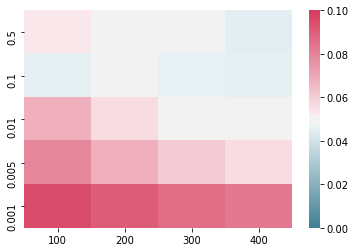

Y7.I.0 variance
            100       200       300       400
0.5    0.122749  0.152542  0.134950  0.175476
0.1    0.150319  0.156468  0.150637  0.160092
0.01   0.275584  0.203124  0.175946  0.169415
0.005  0.452648  0.280051  0.229071  0.198847
0.001  1.698996  0.920306  0.660029  0.527393


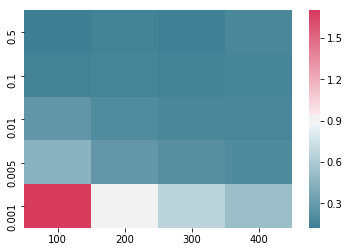

Y7.I.0 test
            100       200       300       400
0.5    0.880981  0.868522  0.878564  0.866187
0.1    0.892582  0.893218  0.895566  0.892781
0.01   0.696399  0.839024  0.874549  0.884527
0.005  0.465400  0.694996  0.793351  0.839999
0.001  0.055730  0.188698  0.297744  0.389594


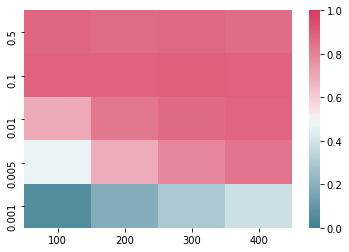

Y7.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999841  0.999997  1.000000  1.000000
0.01   0.828863  0.964274  0.990448  0.996442
0.005  0.595957  0.828487  0.923635  0.963996
0.001  0.168179  0.307312  0.421634  0.516839


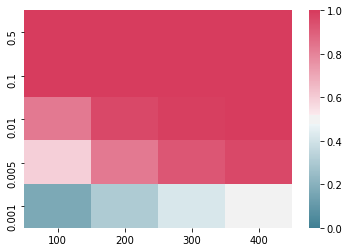

Y7.I.0 bcstd
            100       200       300       400
0.5    0.030827  0.041225  0.037371  0.039231
0.1    0.036987  0.037210  0.036887  0.037125
0.01   0.054658  0.043616  0.040309  0.039101
0.005  0.068339  0.055271  0.047538  0.043505
0.001  0.082993  0.078587  0.074538  0.070975


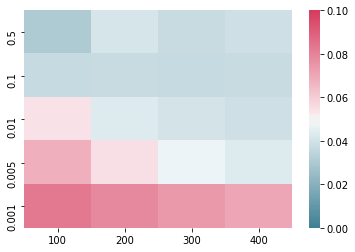

channel 1
file length is 20
Y0.R.0 variance
            100       200       300       400
0.5    0.210289  0.350546  0.234994  0.250230
0.1    0.241964  0.238441  0.250789  0.252892
0.01   0.397111  0.302171  0.273955  0.249787
0.005  0.579886  0.391750  0.331903  0.301160
0.001  1.964467  1.097428  0.813019  0.666751


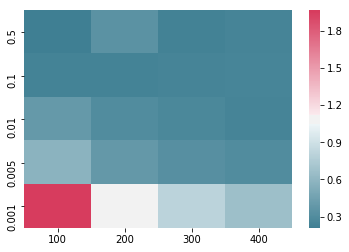

Y0.R.0 test
            100       200       300       400
0.5    0.925511  0.882327  0.918567  0.912562
0.1    0.920108  0.921328  0.917362  0.916699
0.01   0.744462  0.882186  0.907422  0.917572
0.005  0.499261  0.745156  0.841843  0.882271
0.001  0.051626  0.197429  0.316863  0.416647


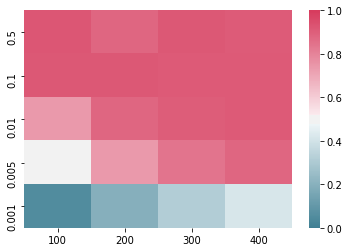

Y0.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860864  0.980433  0.997206  0.999599
0.005  0.626380  0.860029  0.947431  0.980223
0.001  0.178887  0.325632  0.445746  0.544645


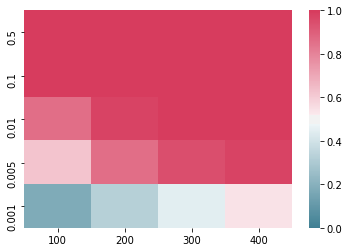

Y0.R.0 bcstd
            100       200       300       400
0.5    0.045390  0.063295  0.047284  0.048589
0.1    0.050547  0.048156  0.051497  0.050035
0.01   0.070587  0.059082  0.054806  0.050599
0.005  0.081742  0.069563  0.062886  0.058963
0.001  0.095763  0.091543  0.087766  0.084393


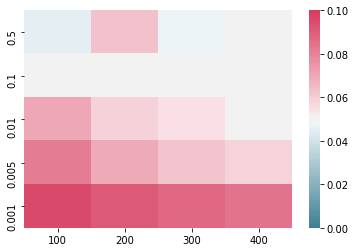

Y0.R.1 variance
            100       200       300       400
0.5    0.220960  0.230632  0.233962  0.212303
0.1    0.230857  0.216939  0.224538  0.217097
0.01   0.385368  0.277024  0.248996  0.231507
0.005  0.554483  0.379402  0.310407  0.280443
0.001  1.944597  1.085301  0.798230  0.651995


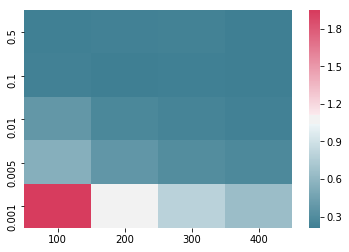

Y0.R.1 test
            100       200       300       400
0.5    0.922249  0.918145  0.916926  0.924700
0.1    0.923532  0.927837  0.925222  0.927866
0.01   0.746845  0.889458  0.914818  0.923021
0.005  0.504352  0.748135  0.847751  0.887997
0.001  0.052689  0.198727  0.319317  0.419248


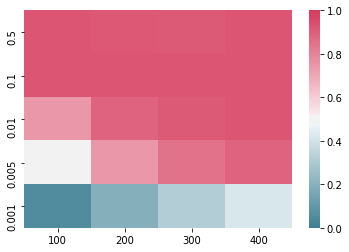

Y0.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860675  0.980379  0.997213  0.999600
0.005  0.626464  0.859996  0.947367  0.980213
0.001  0.178754  0.325512  0.445850  0.544661


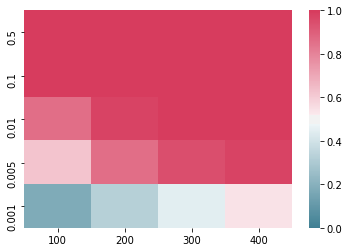

Y0.R.1 bcstd
            100       200       300       400
0.5    0.046722  0.043587  0.046955  0.043330
0.1    0.046936  0.043917  0.045638  0.045303
0.01   0.068713  0.055244  0.049755  0.047423
0.005  0.079332  0.068093  0.059841  0.055159
0.001  0.095464  0.091143  0.087272  0.083589


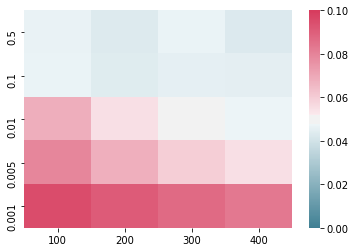

Y0.I.0 variance
            100       200       300       400
0.5    0.716897  0.462465  0.471385  0.508503
0.1    0.579410  0.602081  0.544791  0.606420
0.01   0.663200  0.640001  0.624221  0.607062
0.005  0.793848  0.657216  0.635159  0.616636
0.001  2.005690  1.253703  1.000238  0.876178


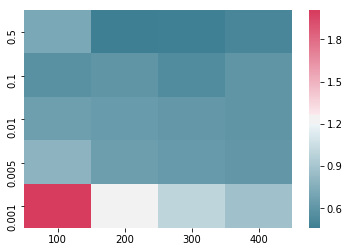

Y0.I.0 test
            100       200       300       400
0.5    0.733682  0.811723  0.809660  0.797964
0.1    0.784782  0.777914  0.795911  0.777124
0.01   0.648565  0.750887  0.769846  0.777658
0.005  0.441030  0.649679  0.725467  0.757500
0.001  0.043585  0.172484  0.278963  0.366185


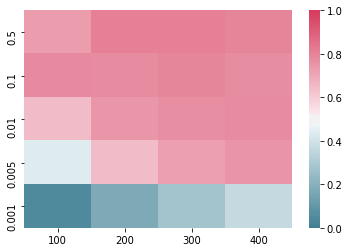

Y0.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999899  0.999997  1.000000  1.000000
0.01   0.847564  0.971986  0.992991  0.997547
0.005  0.615080  0.846728  0.936217  0.971780
0.001  0.175032  0.319124  0.437166  0.534553


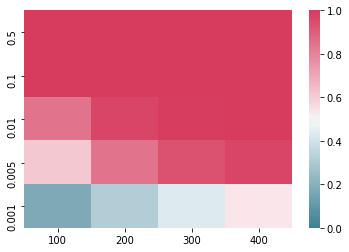

Y0.I.0 bcstd
            100       200       300       400
0.5    0.116222  0.085207  0.088186  0.088874
0.1    0.100115  0.104769  0.099704  0.102192
0.01   0.098626  0.103157  0.104176  0.103464
0.005  0.097223  0.097639  0.099856  0.100645
0.001  0.095076  0.096200  0.096613  0.097107


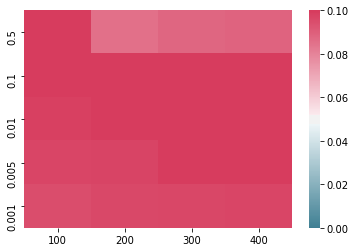

Y0.I.1 variance
            100       200       300       400
0.5    0.142830  0.238042  0.236343  0.107856
0.1    0.089346  0.099170  0.111451  0.114697
0.01   0.150431  0.117718  0.108616  0.112229
0.005  0.193009  0.152222  0.143091  0.121794
0.001  0.460796  0.291057  0.231733  0.212718


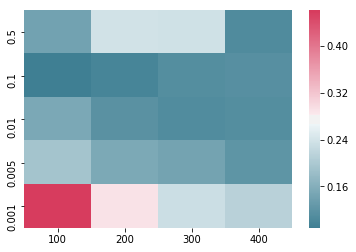

Y0.I.1 test
            100       200       300       400
0.5    0.657249  0.618819  0.624161  0.690010
0.1    0.727603  0.726244  0.729525  0.723988
0.01   0.569555  0.687757  0.717682  0.722087
0.005  0.394716  0.568395  0.645310  0.687571
0.001  0.084174  0.185715  0.269632  0.336485


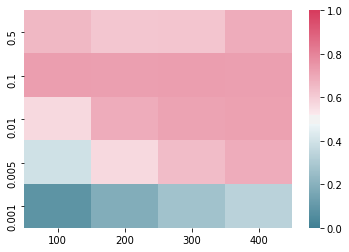

Y0.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999146  0.999980  0.999999  1.000000
0.01   0.786530  0.936234  0.974282  0.987183
0.005  0.554191  0.785563  0.887197  0.936257
0.001  0.154418  0.282590  0.390423  0.479227


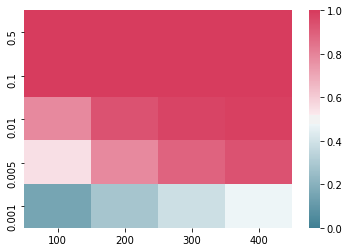

Y0.I.1 bcstd
            100       200       300       400
0.5    0.013771  0.024253  0.032150  0.009303
0.1    0.002646  0.004974  0.003118  0.001222
0.01   0.022853  0.012186  0.004966  0.009303
0.005  0.029198  0.023215  0.021181  0.014815
0.001  0.033338  0.031820  0.030862  0.030485


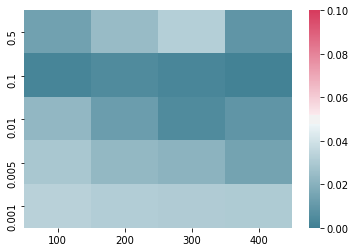

Y1.R.0 variance
            100       200       300       400
0.5    0.219940  0.201738  0.224978  0.263411
0.1    0.244286  0.249288  0.251717  0.251658
0.01   0.391279  0.294795  0.263792  0.246328
0.005  0.573173  0.394274  0.332380  0.304233
0.001  1.965868  1.101280  0.811206  0.669842


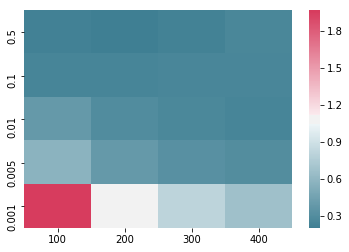

Y1.R.0 test
            100       200       300       400
0.5    0.922696  0.929505  0.920584  0.908514
0.1    0.919150  0.917893  0.916675  0.917181
0.01   0.746280  0.884472  0.910571  0.918654
0.005  0.500736  0.744670  0.841989  0.881349
0.001  0.051487  0.196921  0.317296  0.415921


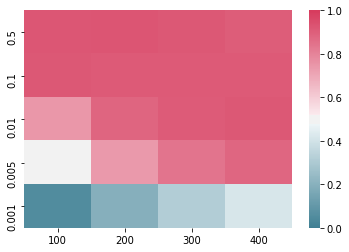

Y1.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860899  0.980402  0.997213  0.999602
0.005  0.626514  0.859990  0.947474  0.980168
0.001  0.178860  0.325573  0.445778  0.544553


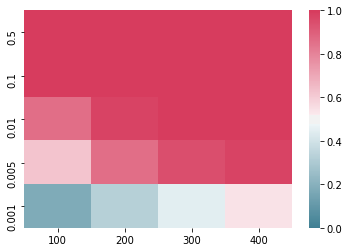

Y1.R.0 bcstd
            100       200       300       400
0.5    0.046424  0.045163  0.046319  0.054244
0.1    0.051089  0.051805  0.053311  0.053355
0.01   0.070078  0.058561  0.053539  0.051451
0.005  0.080990  0.070570  0.063811  0.059927
0.001  0.095877  0.091627  0.087995  0.084858


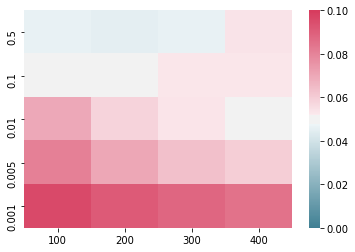

Y1.R.1 variance
            100       200       300       400
0.5    0.207486  0.212618  0.240086  0.253169
0.1    0.225371  0.224441  0.208998  0.211327
0.01   0.373822  0.272315  0.241010  0.237987
0.005  0.560259  0.375219  0.310462  0.276923
0.001  1.960436  1.090642  0.792015  0.649403


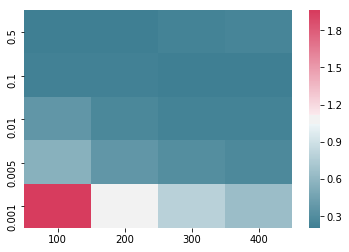

Y1.R.1 test
            100       200       300       400
0.5    0.927017  0.925566  0.914253  0.911365
0.1    0.924927  0.924882  0.929988  0.929473
0.01   0.750046  0.891268  0.917443  0.921050
0.005  0.503749  0.749692  0.848037  0.889443
0.001  0.052063  0.198443  0.320291  0.420097


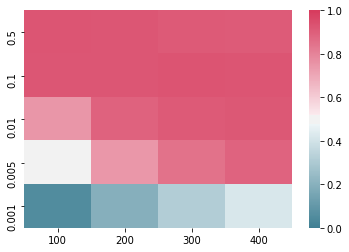

Y1.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860764  0.980416  0.997196  0.999599
0.005  0.626440  0.860137  0.947449  0.980197
0.001  0.178748  0.325566  0.445895  0.544647


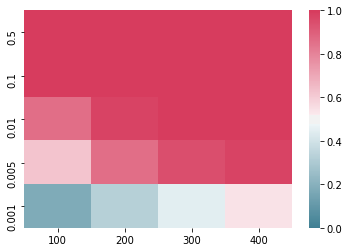

Y1.R.1 bcstd
            100       200       300       400
0.5    0.041686  0.046750  0.048707  0.052519
0.1    0.046549  0.046887  0.042814  0.044936
0.01   0.068602  0.056185  0.050346  0.049916
0.005  0.080770  0.069021  0.061354  0.056172
0.001  0.095814  0.091412  0.087334  0.084094


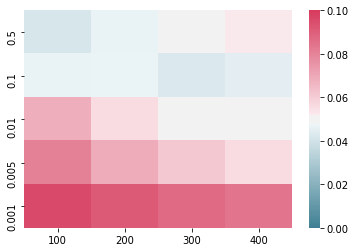

Y1.I.0 variance
            100       200       300       400
0.5    0.760090  0.668355  0.718256  0.568803
0.1    0.675146  0.656452  0.567439  0.591378
0.01   0.719750  0.641644  0.615667  0.608888
0.005  0.847791  0.717695  0.696748  0.642576
0.001  2.122986  1.318751  1.042118  0.917650


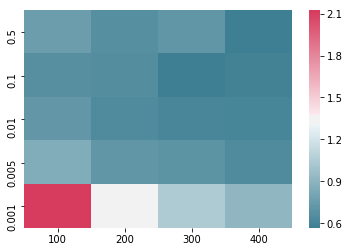

Y1.I.0 test
            100       200       300       400
0.5    0.726776  0.756561  0.737895  0.783367
0.1    0.757473  0.764021  0.791346  0.784572
0.01   0.633322  0.750793  0.773870  0.778506
0.005  0.430720  0.632577  0.707036  0.749995
0.001  0.037915  0.166635  0.273769  0.360365


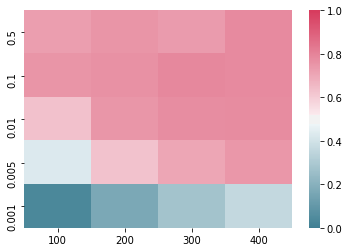

Y1.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999903  0.999997  1.000000  1.000000
0.01   0.845588  0.970900  0.992511  0.997506
0.005  0.612967  0.845102  0.934713  0.970731
0.001  0.174395  0.317644  0.435429  0.532383


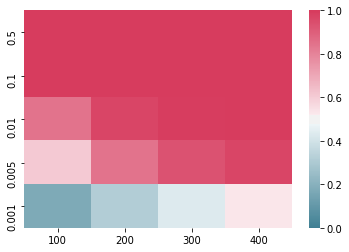

Y1.I.0 bcstd
            100       200       300       400
0.5    0.114433  0.109879  0.112909  0.102151
0.1    0.109092  0.105493  0.096391  0.100926
0.01   0.099288  0.097693  0.097625  0.098642
0.005  0.097808  0.098877  0.101513  0.098040
0.001  0.096882  0.097112  0.096921  0.097142


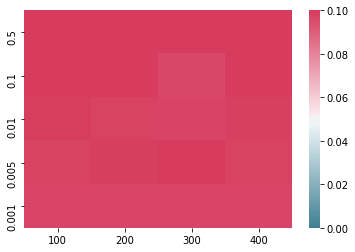

Y1.I.1 variance
            100       200       300       400
0.5    0.121959  0.115325  0.103624  0.105992
0.1    0.100121  0.109338  0.114331  0.112037
0.01   0.150313  0.116895  0.113271  0.109957
0.005  0.203871  0.137227  0.124388  0.118911
0.001  0.668712  0.378261  0.275257  0.228160


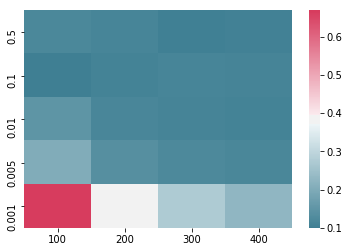

Y1.I.1 test
            100       200       300       400
0.5    0.765205  0.766486  0.760439  0.776210
0.1    0.816112  0.813204  0.803409  0.811709
0.01   0.643574  0.769003  0.798384  0.807974
0.005  0.443279  0.646893  0.730770  0.767439
0.001  0.090158  0.204007  0.299002  0.378791


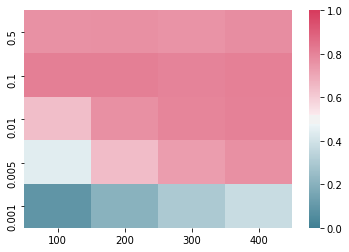

Y1.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999567  0.999985  0.999999  1.000000
0.01   0.812253  0.952940  0.983698  0.992330
0.005  0.577154  0.811657  0.909573  0.952908
0.001  0.162080  0.295997  0.406934  0.499833


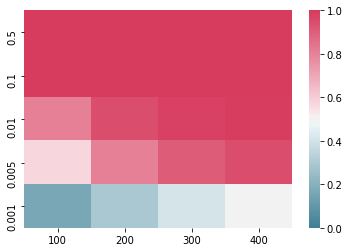

Y1.I.1 bcstd
            100       200       300       400
0.5    0.000819  0.024365  0.001136  0.007576
0.1    0.007012  0.001094  0.011371  0.003068
0.01   0.027386  0.016488  0.013965  0.010212
0.005  0.036602  0.022154  0.018235  0.015815
0.001  0.045080  0.042329  0.039229  0.036542


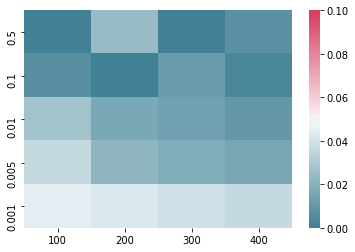

Y2.R.0 variance
            100       200       300       400
0.5    0.194718  0.248304  0.225446  0.280801
0.1    0.243560  0.258242  0.265013  0.234183
0.01   0.392977  0.291474  0.269110  0.252859
0.005  0.579818  0.393802  0.331162  0.294115
0.001  1.964012  1.102410  0.811456  0.665004


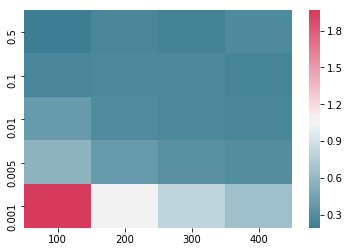

Y2.R.0 test
            100       200       300       400
0.5    0.929270  0.912876  0.920047  0.900744
0.1    0.919442  0.914857  0.912870  0.922159
0.01   0.745725  0.885534  0.908901  0.916464
0.005  0.498889  0.744428  0.842486  0.884659
0.001  0.051420  0.196575  0.317046  0.416748


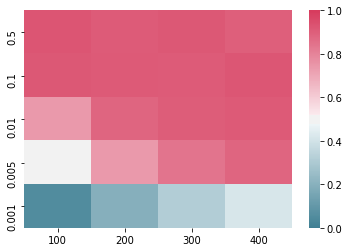

Y2.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860861  0.980398  0.997207  0.999600
0.005  0.626564  0.860007  0.947366  0.980230
0.001  0.178794  0.325460  0.445749  0.544565


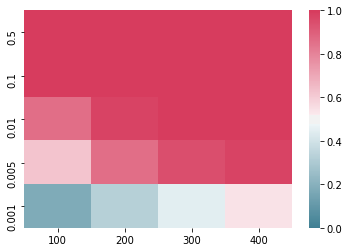

Y2.R.0 bcstd
            100       200       300       400
0.5    0.044655  0.046879  0.045990  0.051610
0.1    0.048643  0.053687  0.054619  0.049810
0.01   0.070104  0.058474  0.054809  0.052044
0.005  0.081798  0.070191  0.063828  0.058822
0.001  0.095800  0.091568  0.087831  0.084494


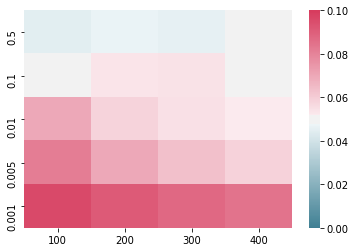

Y2.R.1 variance
            100       200       300       400
0.5    0.192558  0.245098  0.206438  0.215868
0.1    0.232175  0.231102  0.223683  0.229071
0.01   0.374766  0.278603  0.246220  0.230222
0.005  0.566477  0.381125  0.308175  0.274957
0.001  1.953689  1.085871  0.796352  0.651166


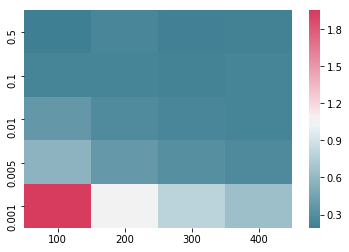

Y2.R.1 test
            100       200       300       400
0.5    0.930643  0.907670  0.926185  0.923225
0.1    0.922524  0.923317  0.925597  0.923949
0.01   0.750517  0.888785  0.915816  0.923335
0.005  0.502928  0.748059  0.849034  0.890062
0.001  0.052466  0.198689  0.319685  0.419508


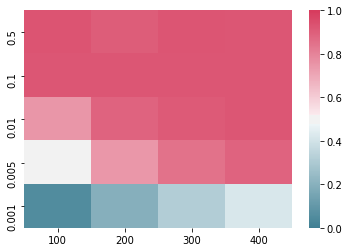

Y2.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860747  0.980318  0.997213  0.999598
0.005  0.626483  0.860013  0.947386  0.980181
0.001  0.178849  0.325351  0.445826  0.544594


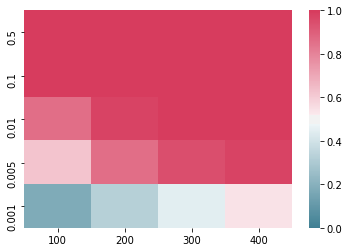

Y2.R.1 bcstd
            100       200       300       400
0.5    0.041819  0.047222  0.047923  0.048773
0.1    0.048046  0.048910  0.046986  0.049550
0.01   0.069192  0.056427  0.051187  0.048012
0.005  0.081377  0.069680  0.060999  0.056272
0.001  0.095703  0.091400  0.087475  0.084122


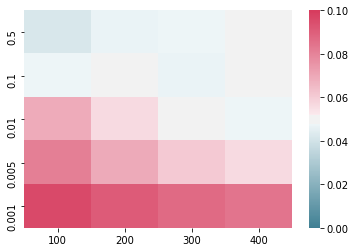

Y2.I.0 variance
            100       200       300       400
0.5    0.520045  0.771609  1.019886  0.432490
0.1    0.632367  0.570353  0.548757  0.538476
0.01   0.699677  0.639535  0.606244  0.588540
0.005  0.849490  0.712912  0.649494  0.616856
0.001  2.116389  1.320324  1.045390  0.915043


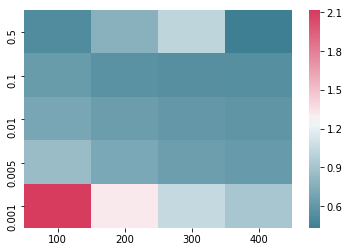

Y2.I.0 test
            100       200       300       400
0.5    0.796582  0.716097  0.638948  0.824340
0.1    0.768179  0.785820  0.795413  0.796200
0.01   0.635598  0.747976  0.772244  0.781667
0.005  0.429163  0.632431  0.718105  0.754151
0.001  0.037897  0.165815  0.272728  0.359732


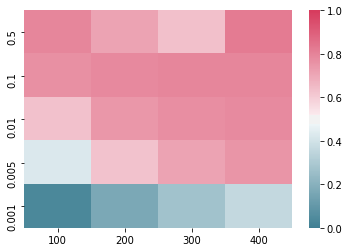

Y2.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999886  0.999997  1.000000  1.000000
0.01   0.845411  0.970889  0.992593  0.997427
0.005  0.612743  0.845195  0.934760  0.970767
0.001  0.174400  0.317558  0.435575  0.532584


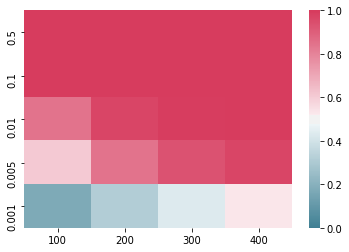

Y2.I.0 bcstd
            100       200       300       400
0.5    0.084231  0.112589  0.132693  0.082373
0.1    0.099256  0.093952  0.090211  0.091552
0.01   0.097407  0.096667  0.095417  0.095432
0.005  0.097879  0.098533  0.097028  0.095585
0.001  0.096634  0.096996  0.097013  0.096899


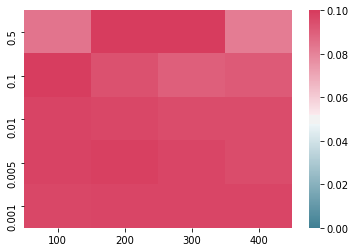

Y2.I.1 variance
            100       200       300       400
0.5    0.113946  0.104458  0.111013  0.107147
0.1    0.105683  0.111234  0.115039  0.124103
0.01   0.147603  0.116215  0.116444  0.114327
0.005  0.192407  0.145507  0.124125  0.119811
0.001  0.640654  0.379253  0.271144  0.223617


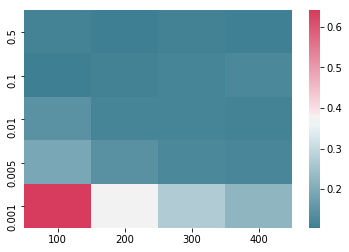

Y2.I.1 test
            100       200       300       400
0.5    0.766358  0.769745  0.757948  0.784013
0.1    0.806450  0.807498  0.808175  0.808213
0.01   0.646476  0.770097  0.798551  0.804828
0.005  0.448585  0.645159  0.731918  0.769360
0.001  0.092237  0.205023  0.301818  0.380275


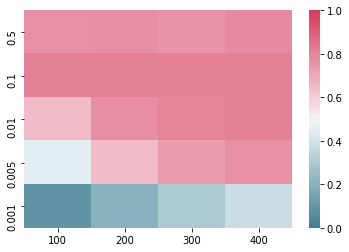

Y2.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999577  0.999988  1.000000  1.000000
0.01   0.810570  0.951890  0.982848  0.992117
0.005  0.576901  0.809748  0.907281  0.951546
0.001  0.161699  0.295516  0.406458  0.498497


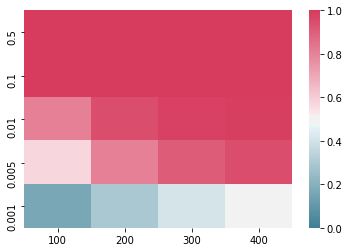

Y2.I.1 bcstd
            100       200       300       400
0.5    0.003610  0.020973  0.012179  0.012747
0.1    0.000820  0.004868  0.008215  0.009440
0.01   0.024672  0.011639  0.011703  0.009739
0.005  0.032126  0.024774  0.014144  0.012541
0.001  0.043318  0.041658  0.037868  0.035152


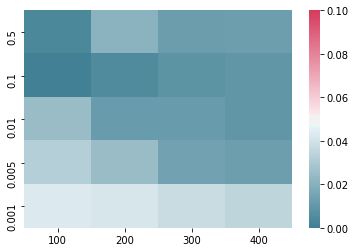

Y3.R.0 variance
            100       200       300       400
0.5    0.267482  0.315307  0.199563  0.270505
0.1    0.232596  0.220235  0.224054  0.231918
0.01   0.387189  0.279763  0.260255  0.245664
0.005  0.564177  0.385773  0.325317  0.291313
0.001  1.959009  1.087175  0.805739  0.661233


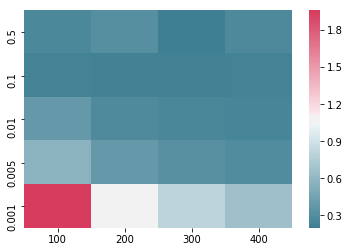

Y3.R.0 test
            100       200       300       400
0.5    0.909021  0.892644  0.927782  0.906783
0.1    0.922765  0.926903  0.925578  0.923093
0.01   0.747055  0.889008  0.911685  0.918741
0.005  0.502575  0.746795  0.844100  0.885323
0.001  0.051870  0.197953  0.317855  0.416910


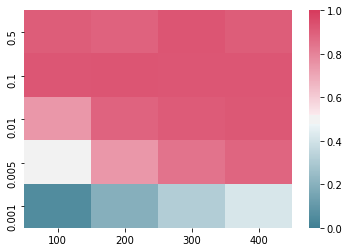

Y3.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860942  0.980393  0.997206  0.999600
0.005  0.626518  0.859971  0.947378  0.980176
0.001  0.178789  0.325447  0.445778  0.544561


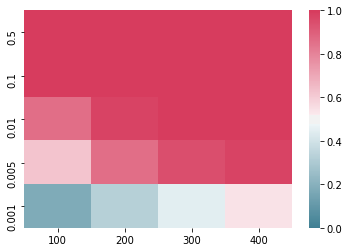

Y3.R.0 bcstd
            100       200       300       400
0.5    0.056322  0.059766  0.041171  0.054568
0.1    0.050379  0.046143  0.047352  0.047706
0.01   0.069287  0.056490  0.053827  0.051087
0.005  0.080502  0.069721  0.062883  0.058072
0.001  0.095821  0.091121  0.087722  0.084242


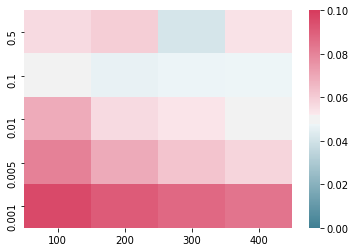

Y3.R.1 variance
            100       200       300       400
0.5    0.200725  0.192923  0.209782  0.211035
0.1    0.203392  0.203025  0.203961  0.210502
0.01   0.363088  0.259421  0.226304  0.213892
0.005  0.547605  0.363030  0.295174  0.259778
0.001  1.941412  1.067822  0.783040  0.631538


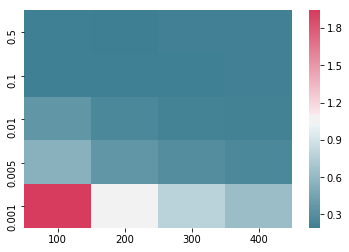

Y3.R.1 test
            100       200       300       400
0.5    0.927645  0.930347  0.924732  0.926077
0.1    0.931752  0.932085  0.931523  0.929628
0.01   0.753067  0.894603  0.921830  0.928462
0.005  0.505811  0.752832  0.852530  0.894662
0.001  0.052930  0.200452  0.321637  0.422733


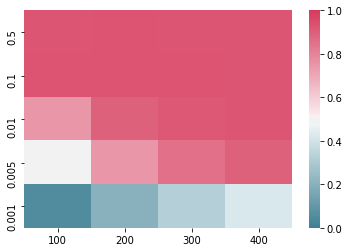

Y3.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860658  0.980379  0.997202  0.999596
0.005  0.626364  0.860061  0.947400  0.980190
0.001  0.178732  0.325499  0.445785  0.544563


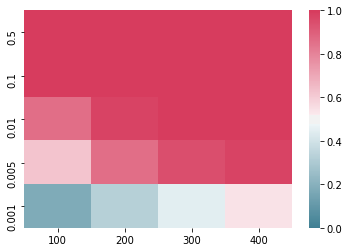

Y3.R.1 bcstd
            100       200       300       400
0.5    0.045323  0.042673  0.045107  0.051550
0.1    0.043017  0.044505  0.043268  0.044299
0.01   0.067250  0.052976  0.048372  0.045779
0.005  0.080145  0.067629  0.059033  0.053882
0.001  0.095470  0.090835  0.086987  0.082959


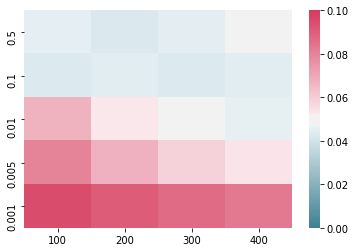

Y3.I.0 variance
            100       200       300       400
0.5    0.545238  0.576112  0.574819  0.570353
0.1    0.606553  0.574392  0.646959  0.558097
0.01   0.687087  0.593041  0.606559  0.576451
0.005  0.815952  0.703064  0.658509  0.616157
0.001  2.102173  1.317046  1.030746  0.920848


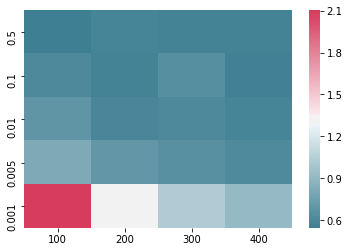

Y3.I.0 test
            100       200       300       400
0.5    0.790441  0.777348  0.774618  0.781012
0.1    0.776538  0.786676  0.764636  0.790985
0.01   0.638221  0.761240  0.772543  0.785604
0.005  0.433517  0.634068  0.714402  0.754234
0.001  0.038463  0.165114  0.273424  0.356995


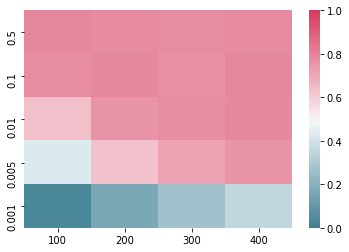

Y3.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999881  0.999997  1.000000  1.000000
0.01   0.845255  0.970247  0.992322  0.997304
0.005  0.612742  0.844594  0.933952  0.970192
0.001  0.174077  0.317149  0.435276  0.531941


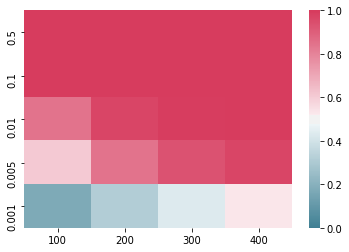

Y3.I.0 bcstd
            100       200       300       400
0.5    0.087794  0.101390  0.098817  0.099455
0.1    0.100333  0.093481  0.104818  0.096134
0.01   0.097636  0.094176  0.097021  0.095874
0.005  0.096236  0.098969  0.098169  0.096562
0.001  0.096527  0.097285  0.096848  0.097975


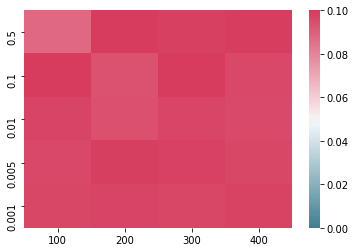

Y3.I.1 variance
            100       200       300       400
0.5    0.130685  0.199670  0.121038  0.118061
0.1    0.117931  0.122450  0.118708  0.115823
0.01   0.124950  0.118565  0.116713  0.118261
0.005  0.175545  0.128040  0.118602  0.117738
0.001  0.678586  0.349443  0.257817  0.201254


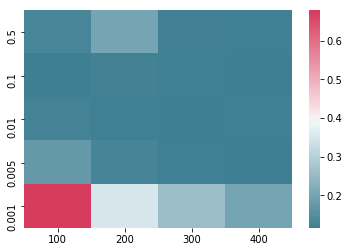

Y3.I.1 test
            100       200       300       400
0.5    0.766977  0.739121  0.763232  0.755993
0.1    0.806582  0.805493  0.803451  0.799600
0.01   0.638183  0.759128  0.788163  0.796972
0.005  0.427518  0.633005  0.720011  0.760010
0.001  0.082785  0.193288  0.283593  0.361756


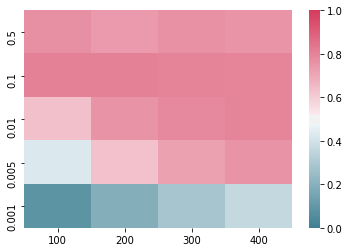

Y3.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999540  0.999991  1.000000  1.000000
0.01   0.791633  0.939910  0.976630  0.989109
0.005  0.555340  0.789456  0.892735  0.939498
0.001  0.154390  0.281639  0.389071  0.478836


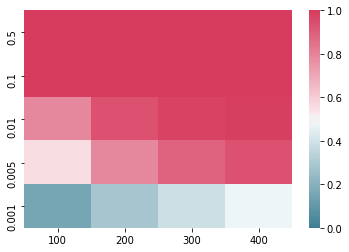

Y3.I.1 bcstd
            100       200       300       400
0.5    0.034930  0.016176  0.006337  0.016425
0.1    0.001506  0.008307  0.003452  0.007033
0.01   0.009236  0.003448  0.000431  0.002534
0.005  0.026365  0.011438  0.003072  0.002297
0.001  0.043691  0.038187  0.034514  0.029249


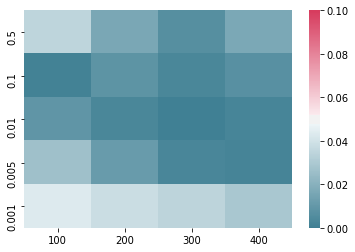

Y4.R.0 variance
            100       200       300       400
0.5    0.290047  0.223978  0.223369  0.233614
0.1    0.276672  0.244592  0.247253  0.243457
0.01   0.393174  0.303874  0.263932  0.257576
0.005  0.576131  0.392996  0.329600  0.295867
0.001  1.967557  1.097674  0.804650  0.663164


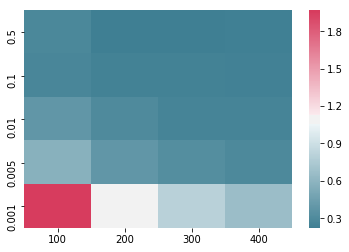

Y4.R.0 test
            100       200       300       400
0.5    0.900625  0.920368  0.921560  0.917088
0.1    0.908727  0.918867  0.918108  0.919197
0.01   0.745906  0.881492  0.910392  0.914814
0.005  0.499996  0.744783  0.842654  0.883983
0.001  0.051440  0.196920  0.317954  0.417083


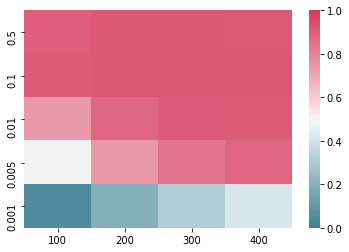

Y4.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860767  0.980400  0.997220  0.999602
0.005  0.626521  0.860041  0.947479  0.980210
0.001  0.178796  0.325457  0.445773  0.544640


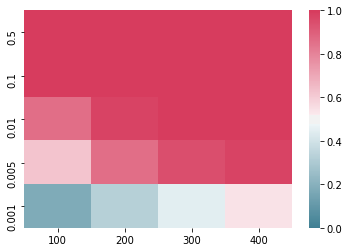

Y4.R.0 bcstd
            100       200       300       400
0.5    0.057299  0.046757  0.045346  0.048128
0.1    0.053232  0.049664  0.050738  0.048876
0.01   0.070015  0.059653  0.053709  0.052867
0.005  0.080982  0.069792  0.063014  0.058531
0.001  0.095854  0.091373  0.087501  0.084200


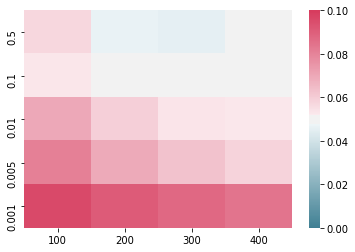

Y4.R.1 variance
            100       200       300       400
0.5    0.246456  0.218108  0.205163  0.219838
0.1    0.218751  0.208546  0.221032  0.209534
0.01   0.366324  0.272053  0.240162  0.222203
0.005  0.555843  0.367184  0.302623  0.271831
0.001  1.951330  1.082886  0.787734  0.642149


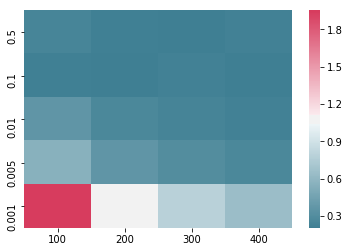

Y4.R.1 test
            100       200       300       400
0.5    0.914410  0.922147  0.925588  0.921598
0.1    0.926954  0.930276  0.926035  0.929949
0.01   0.752803  0.890758  0.917416  0.925739
0.005  0.504421  0.752171  0.850397  0.890808
0.001  0.052353  0.198847  0.320811  0.421013


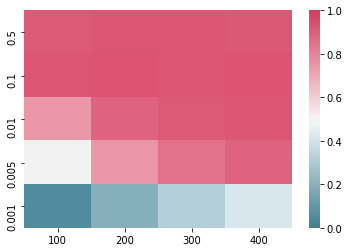

Y4.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860748  0.980388  0.997202  0.999598
0.005  0.626642  0.860053  0.947363  0.980203
0.001  0.178848  0.325422  0.445753  0.544613


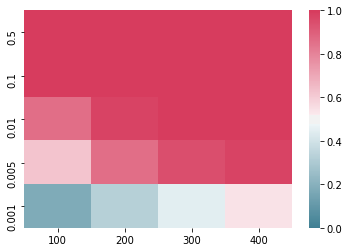

Y4.R.1 bcstd
            100       200       300       400
0.5    0.048511  0.047109  0.041376  0.046351
0.1    0.046039  0.045439  0.046412  0.044700
0.01   0.067134  0.054040  0.049435  0.046660
0.005  0.080283  0.067300  0.059402  0.054777
0.001  0.095528  0.091172  0.086870  0.083075


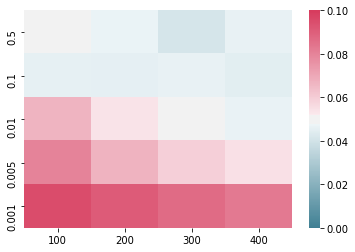

Y4.I.0 variance
            100       200       300       400
0.5    0.596897  0.626846  0.759985  0.652861
0.1    0.512898  0.553886  0.650358  0.732304
0.01   0.701994  0.632886  0.591843  0.628241
0.005  0.815910  0.695571  0.651922  0.663077
0.001  2.062866  1.293008  1.030654  0.898156


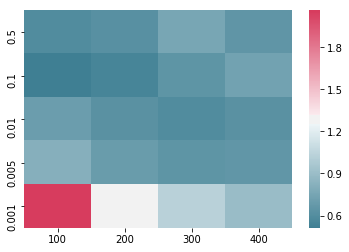

Y4.I.0 test
            100       200       300       400
0.5    0.764691  0.760412  0.717847  0.754667
0.1    0.804843  0.790785  0.761386  0.735668
0.01   0.632934  0.748080  0.775987  0.767212
0.005  0.433459  0.634232  0.714906  0.738891
0.001  0.041037  0.168322  0.273697  0.360700


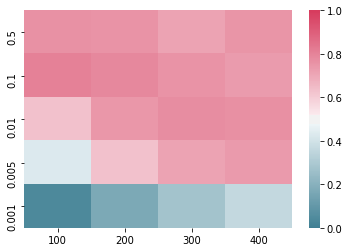

Y4.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999868  0.999996  1.000000  1.000000
0.01   0.844476  0.969614  0.991745  0.996791
0.005  0.611815  0.843770  0.933203  0.969310
0.001  0.174231  0.317468  0.435136  0.531721


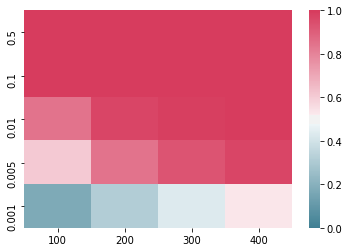

Y4.I.0 bcstd
            100       200       300       400
0.5    0.103754  0.110832  0.115024  0.098728
0.1    0.091173  0.095517  0.106041  0.110141
0.01   0.099306  0.097304  0.094968  0.099262
0.005  0.097308  0.098747  0.097978  0.100193
0.001  0.096074  0.096913  0.097086  0.097138


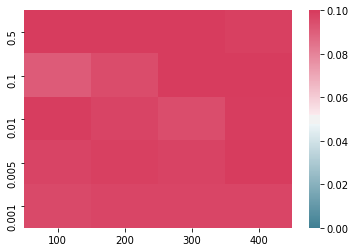

Y4.I.1 variance
            100       200       300       400
0.5    0.113181  0.118202  0.106050  0.168114
0.1    0.111895  0.109790  0.112023  0.110795
0.01   0.139255  0.119500  0.109807  0.111321
0.005  0.201372  0.133580  0.122105  0.116890
0.001  0.680860  0.376288  0.270961  0.226059


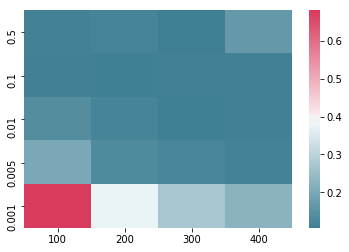

Y4.I.1 test
            100       200       300       400
0.5    0.769126  0.791954  0.767958  0.758866
0.1    0.807189  0.814344  0.811141  0.815895
0.01   0.650623  0.762654  0.793434  0.804763
0.005  0.451966  0.648667  0.727973  0.764279
0.001  0.093256  0.210398  0.307419  0.386283


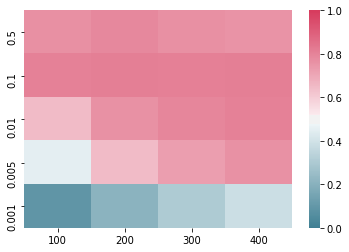

Y4.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999463  0.999987  1.000000  1.000000
0.01   0.800466  0.941526  0.977233  0.989419
0.005  0.571235  0.798549  0.896373  0.940818
0.001  0.160345  0.292975  0.403101  0.494261


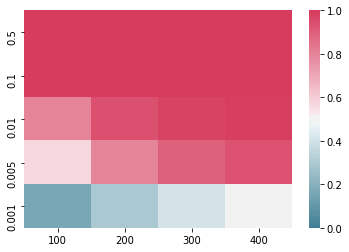

Y4.I.1 bcstd
            100       200       300       400
0.5    0.006634  0.002748  0.005004  0.030007
0.1    0.001024  0.001263  0.001852  0.001107
0.01   0.019622  0.012221  0.004216  0.006255
0.005  0.032795  0.018364  0.011693  0.010836
0.001  0.045479  0.042421  0.038143  0.036072


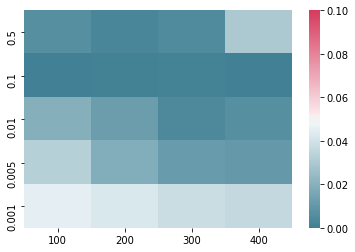

Y5.R.0 variance
            100       200       300       400
0.5    0.222806  0.229316  0.236043  0.231799
0.1    0.236226  0.241205  0.237859  0.236169
0.01   0.388075  0.300030  0.263504  0.249665
0.005  0.574802  0.401887  0.330174  0.301470
0.001  1.960592  1.094387  0.809850  0.663728


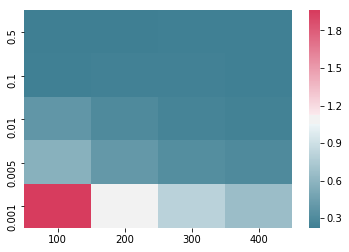

Y5.R.0 test
            100       200       300       400
0.5    0.922037  0.919369  0.917208  0.915227
0.1    0.921507  0.919940  0.920997  0.921869
0.01   0.746528  0.882695  0.910534  0.917371
0.005  0.500382  0.742486  0.842537  0.882118
0.001  0.051761  0.197605  0.317242  0.416539


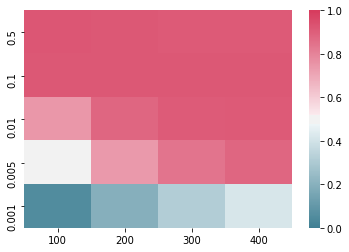

Y5.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860674  0.980389  0.997216  0.999600
0.005  0.626567  0.860004  0.947421  0.980225
0.001  0.178807  0.325558  0.445874  0.544445


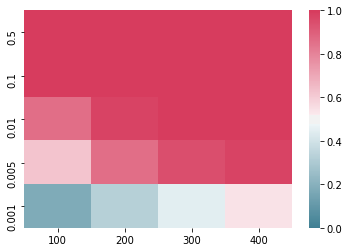

Y5.R.0 bcstd
            100       200       300       400
0.5    0.044763  0.052234  0.048710  0.049213
0.1    0.049484  0.049829  0.048840  0.049260
0.01   0.069011  0.058927  0.053482  0.050962
0.005  0.080907  0.070553  0.063124  0.059026
0.001  0.095766  0.091364  0.087736  0.083966


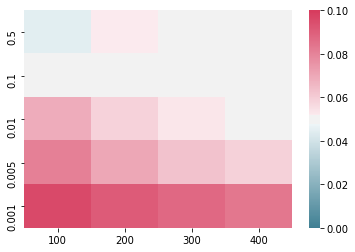

Y5.R.1 variance
            100       200       300       400
0.5    0.199135  0.199839  0.196169  0.211072
0.1    0.207685  0.218940  0.211612  0.205565
0.01   0.368065  0.269222  0.237657  0.221677
0.005  0.553422  0.368474  0.302395  0.271064
0.001  1.955366  1.080807  0.788373  0.642046


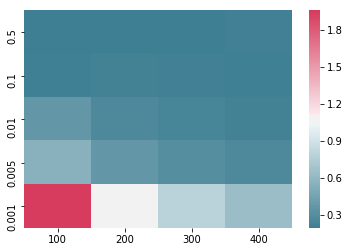

Y5.R.1 test
            100       200       300       400
0.5    0.929499  0.928931  0.929374  0.923741
0.1    0.930493  0.926772  0.928940  0.930985
0.01   0.752056  0.891711  0.918175  0.925861
0.005  0.504480  0.751487  0.850484  0.890817
0.001  0.052048  0.199248  0.320598  0.420919


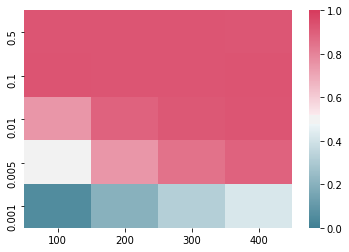

Y5.R.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860803  0.980416  0.997211  0.999598
0.005  0.626472  0.860180  0.947438  0.980209
0.001  0.178757  0.325483  0.445825  0.544529


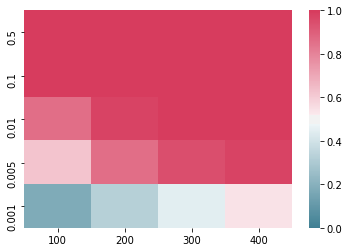

Y5.R.1 bcstd
            100       200       300       400
0.5    0.044720  0.046260  0.045025  0.044103
0.1    0.044989  0.045452  0.044924  0.043978
0.01   0.066945  0.054268  0.049121  0.046228
0.005  0.079566  0.067388  0.059438  0.054260
0.001  0.095531  0.090888  0.086793  0.083049


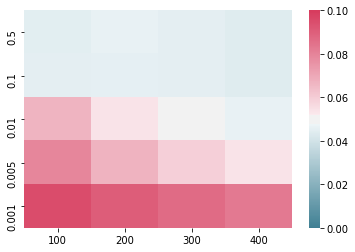

Y5.I.0 variance
            100       200       300       400
0.5    0.731954  0.522265  0.767141  0.500134
0.1    0.724013  0.776325  0.714952  0.632094
0.01   0.674756  0.682486  0.661934  0.649175
0.005  0.819890  0.681674  0.671738  0.680223
0.001  1.927998  1.227843  0.978131  0.872566


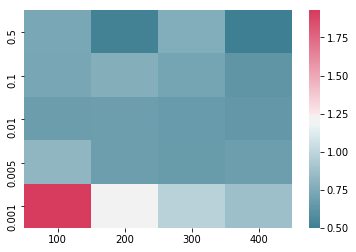

Y5.I.0 test
            100       200       300       400
0.5    0.713721  0.781334  0.703196  0.785440
0.1    0.729797  0.715280  0.732063  0.757845
0.01   0.625055  0.720301  0.744935  0.752547
0.005  0.418855  0.622975  0.695358  0.721770
0.001  0.045289  0.167213  0.270685  0.352244


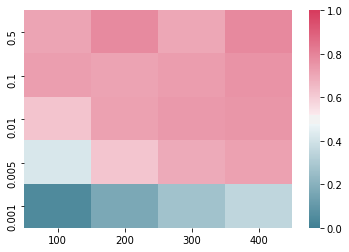

Y5.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999849  0.999996  1.000000  1.000000
0.01   0.842556  0.970160  0.992248  0.997010
0.005  0.609105  0.842122  0.933430  0.970124
0.001  0.173030  0.315156  0.432432  0.528848


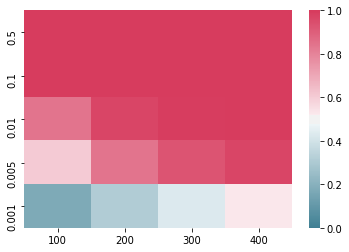

Y5.I.0 bcstd
            100       200       300       400
0.5    0.106916  0.087063  0.112014  0.091150
0.1    0.111590  0.117364  0.111972  0.103849
0.01   0.097775  0.103368  0.103883  0.103612
0.005  0.096512  0.097032  0.099780  0.102558
0.001  0.091689  0.093008  0.093408  0.094458


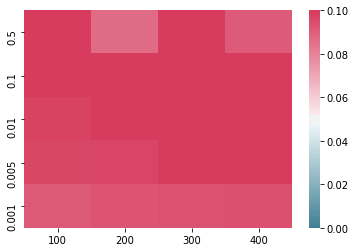

Y5.I.1 variance
            100       200       300       400
0.5    0.121641  0.106326  0.141963  0.120673
0.1    0.119021  0.116232  0.116300  0.115425
0.01   0.134885  0.120578  0.118743  0.118149
0.005  0.188625  0.138147  0.123121  0.120180
0.001  0.627952  0.346314  0.259770  0.217409


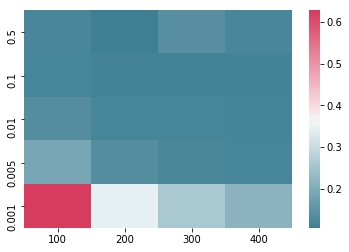

Y5.I.1 test
            100       200       300       400
0.5    0.767438  0.771209  0.734191  0.768483
0.1    0.799928  0.804871  0.804522  0.805773
0.01   0.642105  0.752779  0.781861  0.793537
0.005  0.450266  0.639668  0.720216  0.754565
0.001  0.094433  0.210850  0.305603  0.384141


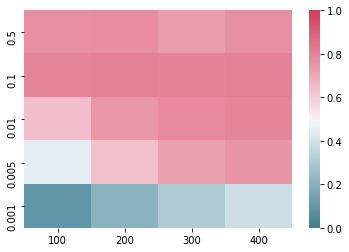

Y5.I.1 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999512  0.999987  1.000000  1.000000
0.01   0.798086  0.941015  0.977790  0.989549
0.005  0.570299  0.798166  0.895397  0.941824
0.001  0.159896  0.292327  0.401492  0.493189


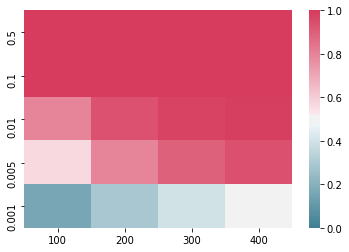

Y5.I.1 bcstd
            100       200       300       400
0.5    0.004556  0.000675  0.005515  0.014680
0.1    0.004286  0.010713  0.000874  0.003271
0.01   0.016582  0.008942  0.003312  0.003554
0.005  0.029477  0.016831  0.009339  0.006857
0.001  0.043369  0.039328  0.036354  0.032534


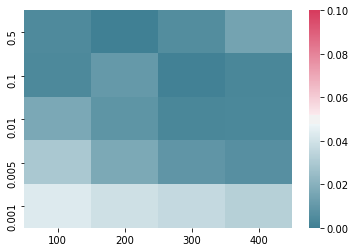

Y6.R.0 variance
            100       200       300       400
0.5    0.211777  0.232170  0.199251  0.218194
0.1    0.208683  0.226823  0.205292  0.208888
0.01   0.367117  0.266552  0.238989  0.223019
0.005  0.547086  0.370283  0.302292  0.268652
0.001  1.946653  1.078934  0.787186  0.641670


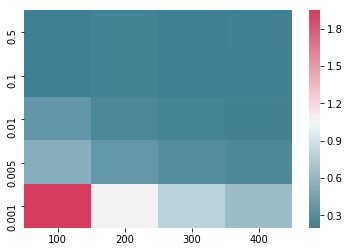

Y6.R.0 test
            100       200       300       400
0.5    0.925187  0.917777  0.926363  0.922304
0.1    0.930305  0.924380  0.931368  0.929601
0.01   0.751417  0.892431  0.917539  0.925343
0.005  0.506359  0.750719  0.850345  0.891582
0.001  0.052574  0.198832  0.320397  0.421047


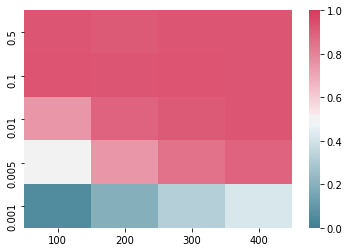

Y6.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860706  0.980324  0.997200  0.999598
0.005  0.626600  0.860008  0.947410  0.980171
0.001  0.178840  0.325398  0.445896  0.544664


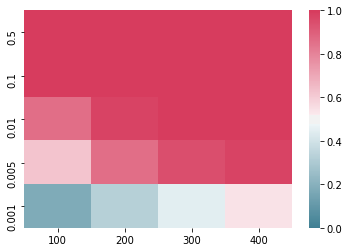

Y6.R.0 bcstd
            100       200       300       400
0.5    0.047633  0.049781  0.043675  0.043803
0.1    0.044964  0.046215  0.044718  0.044611
0.01   0.067140  0.053879  0.048919  0.046286
0.005  0.079458  0.067229  0.059146  0.053936
0.001  0.095527  0.090846  0.086637  0.083187


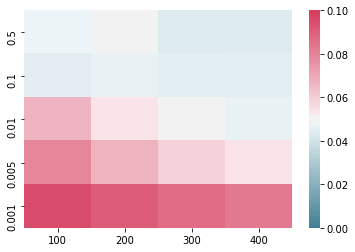

Y6.I.0 variance
            100       200       300       400
0.5    0.114776  0.120042  0.127169  0.129318
0.1    0.115543  0.124822  0.125540  0.128217
0.01   0.130947  0.117762  0.117183  0.118660
0.005  0.171148  0.130056  0.123232  0.119595
0.001  0.511353  0.298786  0.223789  0.189566


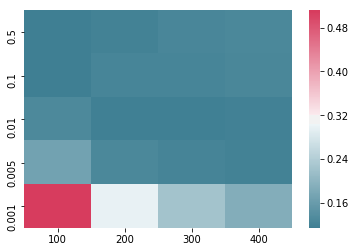

Y6.I.0 test
            100       200       300       400
0.5    0.768189  0.769473  0.762963  0.777529
0.1    0.799128  0.808122  0.806672  0.801241
0.01   0.654005  0.763083  0.786124  0.795179
0.005  0.459073  0.649444  0.728963  0.761303
0.001  0.099805  0.215732  0.312061  0.391872


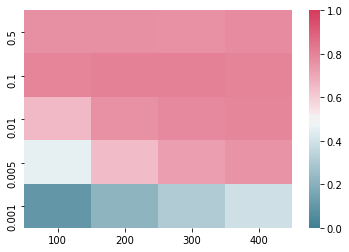

Y6.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999456  0.999989  1.000000  1.000000
0.01   0.801690  0.943545  0.978117  0.989693
0.005  0.572601  0.800682  0.898505  0.943468
0.001  0.160310  0.293350  0.403937  0.495797


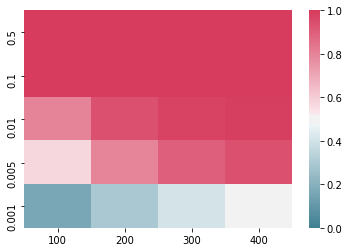

Y6.I.0 bcstd
            100       200       300       400
0.5    0.022886  0.001134  0.000587  0.000354
0.1    0.006324  0.007401  0.005533  0.007910
0.01   0.009523  0.001156  0.000469  0.003305
0.005  0.022265  0.012279  0.005078  0.001955
0.001  0.037190  0.033359  0.029265  0.026372


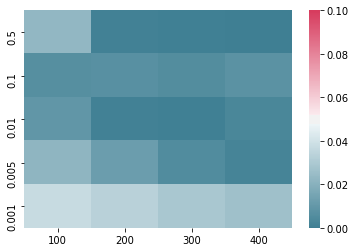

Y7.R.0 variance
            100       200       300       400
0.5    0.218526  0.191151  0.212389  0.246851
0.1    0.203447  0.203771  0.203270  0.211981
0.01   0.364252  0.264868  0.231448  0.219705
0.005  0.545117  0.365101  0.300779  0.266255
0.001  1.931899  1.071058  0.780467  0.636822


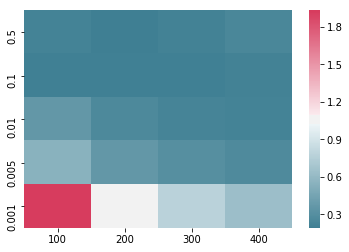

Y7.R.0 test
            100       200       300       400
0.5    0.922181  0.931367  0.925197  0.913667
0.1    0.932176  0.932043  0.931948  0.929421
0.01   0.751964  0.892918  0.920252  0.926676
0.005  0.505503  0.751302  0.850202  0.892434
0.001  0.053210  0.199812  0.320807  0.421413


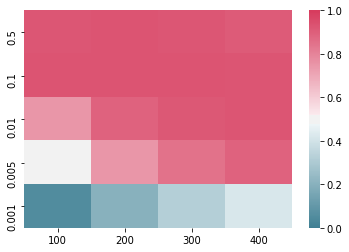

Y7.R.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999999  1.000000  1.000000  1.000000
0.01   0.860519  0.980355  0.997203  0.999600
0.005  0.626560  0.860022  0.947299  0.980202
0.001  0.178787  0.325360  0.445649  0.544482


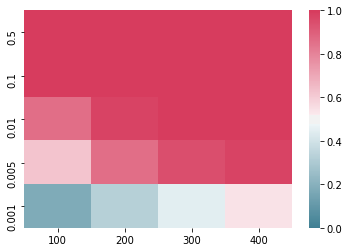

Y7.R.0 bcstd
            100       200       300       400
0.5    0.043274  0.044252  0.045229  0.048596
0.1    0.044065  0.044359  0.043337  0.045315
0.01   0.067032  0.053561  0.048220  0.045773
0.005  0.078974  0.066766  0.059127  0.054525
0.001  0.095182  0.090570  0.086446  0.082960


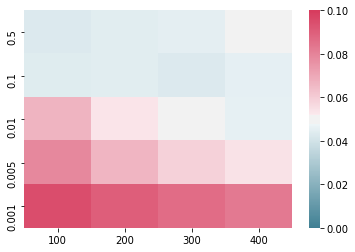

Y7.I.0 variance
            100       200       300       400
0.5    0.110600  0.180333  0.164374  0.133455
0.1    0.143804  0.145697  0.146520  0.139119
0.01   0.173048  0.153561  0.143152  0.148338
0.005  0.252631  0.179361  0.155716  0.147823
0.001  0.792165  0.454017  0.343574  0.285806


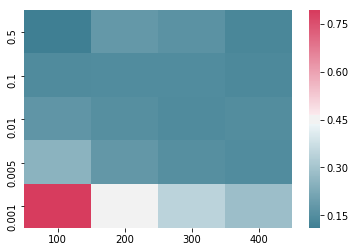

Y7.I.0 test
            100       200       300       400
0.5    0.753130  0.707884  0.706312  0.733905
0.1    0.769957  0.771618  0.778328  0.774747
0.01   0.604414  0.724407  0.755948  0.768847
0.005  0.408809  0.600787  0.686084  0.724997
0.001  0.078973  0.184844  0.273210  0.346414


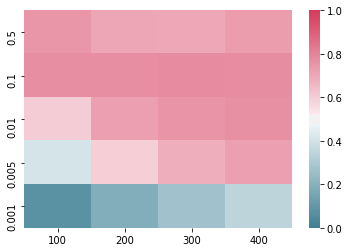

Y7.I.0 train
            100       200       300       400
0.5    1.000000  1.000000  1.000000  1.000000
0.1    0.999408  0.999987  1.000000  1.000000
0.01   0.795782  0.943024  0.978748  0.990008
0.005  0.564199  0.795068  0.896083  0.942524
0.001  0.157298  0.288078  0.396737  0.487241


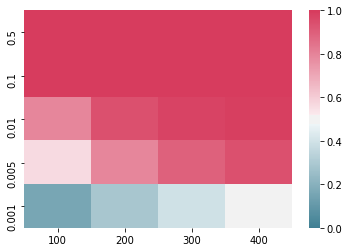

Y7.I.0 bcstd
            100       200       300       400
0.5    0.001191  0.019321  0.004810  0.010021
0.1    0.008627  0.000909  0.004508  0.005854
0.01   0.023592  0.013780  0.008563  0.008437
0.005  0.035224  0.022951  0.016752  0.013753
0.001  0.048431  0.044753  0.040968  0.038787


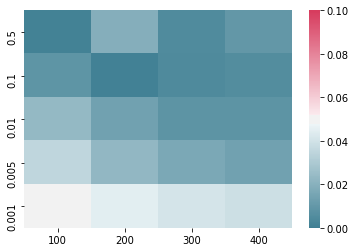

In [193]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as plot
import seaborn as sbn
import re
import math
from itertools import product

# maximum number of channels
chmax = 2

idate = [ '06142019' ]#'0530', '0531' ]#, '0525' ]

# return scores and its deviations from each output file
def read(file): 
    scr = {}
    err = {}
    scr0 = {}
    bs = {}
    with open(file, 'r') as pf:
        m = 0
        stl = None
        cont = False
        for line in pf:
            if 'unlbl' in line:
                unlbl = int(line.split()[-2].split('/')[-1])
            if re.search('Y\d\.(R|I)', line) is not None:
                #print(line)
                nf = line.split()
                try:
                    bs[nf[0]].append(math.sqrt((float(nf[6])-float(nf[1]))**2/float(nf[-7])**2/float(unlbl)))
                    scr[nf[0]].append(float(nf[-3])+bs[nf[0]][-1]**2)#+bs[-1]**2/float(nf[-4]))/float(stl[m]))
                    err[nf[0]].append(abs(float(nf[-1])/float(stl[m])))
                    scr0[nf[0]].append(stl[m])
                except:
                    bs[nf[0]] = [math.sqrt((float(nf[6])-float(nf[1]))**2/(float(nf[-7]))**2/float(unlbl))]
                    scr[nf[0]] = [float(nf[-3])+bs[nf[0]][-1]**2]#+bs[-1]**2/float(nf[-4]))/float(stl[m])]
                    err[nf[0]] = [abs(float(nf[-1])/float(stl[m]))]
                    scr0[nf[0]] = [stl[m]]
                m += 1
            l = line.split()
            try:
                if l[0] == 'score':
                    stl = line.split('[')[1].split(']')[0].split()
                    m = 0
                    if ']' in line:
                        cont = False
                    else:
                        cont = True
                elif cont:
                    stl.extend(line.split(']')[0].split())
                    if ']' in line:
                        cont = False
            except:
                pass
        #print(err)
        pf.close()
    return scr, err, scr0, bs

tabtemp = pds.DataFrame(dtype=float)#, columns=['100', '200', '300', '400'], index=[ '1', '0.5', '0.2', '0.1', '0.01', '0.005', '0.001', '0.0005', '0.0001' ])

def make_table(par, file, ofile):
    tab = {}
    tabv = {}
    tab0 = {}
    tabbss = {}
    n=0
    print("file length is {:}".format(len(file)))
    for j in par:
        for i in par[j]:
            #print(n)
            scrl, errl, scr0l, bs = read(file[n])
            l=0
            for erk in errl:
                m=0
                for err in errl[erk]:
                    #print("err is ", err)
                    if erk+'.'+str(m) in tab:
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    else:
                        tab[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    m+=1
            n+=1
    pf = open(ofile, 'a+')
    m = 0
    try:
        os.mkdir(ofile+'.plot')
    except:
        print("Warning: directory "+ofile+".plot/ already exists!")
    for key in tab:
        fig, ax = mplot.subplots()
        print(key+" variance")
        print(tab[key])
        ax = sbn.heatmap(tab[key], cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pvar.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" test")
        print(tabv[key])
        ax = sbn.heatmap(tabv[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptst.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" train")
        print(tab0[key])
        ax = sbn.heatmap(tab0[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptrn.'+str(m)+'.pdf', format='pdf')
        #pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\n".format(tab[key], tabv[key], tab0[key]))
        fig, ax = mplot.subplots()
        print(key+" bcstd")
        print(tabbss[key])
        ax = sbn.heatmap(tabbss[key], vmin=0.0, vmax=0.1, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pbcstd.'+str(m)+'.pdf', format='pdf')
        pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\nbcstd \n {:} \n\n".format(tab[key], tabv[key], tab0[key], tabbss[key]))
        m += 1
    pf.close()
    del tab
    del tabv
    del tab0
    del tabbss
    return

odir = '/Users/ruizi/Documents/ML/outputs/pdf/meson/ave'

params = {}
for i, j in product([ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):# [ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005 ], [100, 200, 300, 400]):
#for i, j in product([50,10,5], [100])
    try:
        params[str(i)].append(str(j))
    except:
        params[str(i)] = [str(j)]
        
for ch in range(chmax):
    files = []
    for d1, d2, f in os.walk(odir): 
        #print(d1)
        for ddir in d2:
            for dt in idate:
                if dt in ddir:
                    files.append(odir+'/'+ddir+'/CV1.'+str(ch)) 
        break
    files.sort()
    print("channel {:}".format(ch))
    make_table(params, files, odir+'/score.ch'+str(ch))        

In [117]:
import numpy

numpy.random.seed(2019)
print("{:}".format(numpy.random.randint(0,50,10)))
print("{:}".format(numpy.random.randint(0,50,10)))

a=numpy.array([[1,2], [3,4], [5,6]])
print(a.mean(axis=1))
print(abs(a))
a=[[1,2], [3,4], [5,6]]
print(a[0:1])
print(['ML.06122019.0{:02d}'.format(i) for i in range(3, 13) ])

[ 8 31 37 24 24 29 15 12 42 16]
[48  7 37 19 12 16 31  5 24 28]
[1.5 3.5 5.5]
[[1 2]
 [3 4]
 [5 6]]
[[1, 2]]
['ML.06122019.003', 'ML.06122019.004', 'ML.06122019.005', 'ML.06122019.006', 'ML.06122019.007', 'ML.06122019.008', 'ML.06122019.009', 'ML.06122019.010', 'ML.06122019.011', 'ML.06122019.012']


BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
Y = [1.0326002783266903, 1.031798794150118, 1.0317562356569638, 1.0328915629061914] err=[0.008938521938716179, 0.009261547618389307, 0.008766906104613963, 0.009030524969398733]


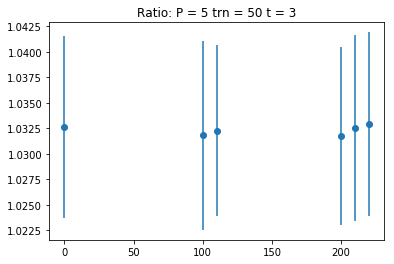

Y = [1.0018445318718108, 0.9998395118791643, 0.9998015592019691, 1.0019109426222652] err=[0.01577845001702864, 0.015846707656823476, 0.016517220573254755, 0.01606733032999657]


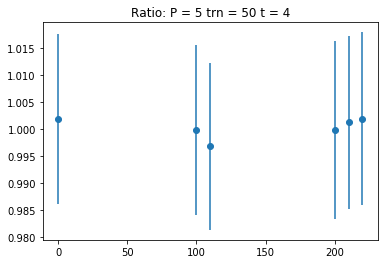

Y = [1.0310425047795493, 1.0310611739205913, 1.0308722968964996] err=[0.008506080406550364, 0.008540316847412804, 0.008357392041771458]


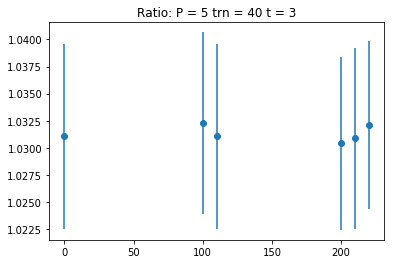

Y = [0.9986957344009617, 0.9973058202837535, 0.9990114722631604] err=[0.015062013848759473, 0.016263760606206143, 0.01579180476897506]


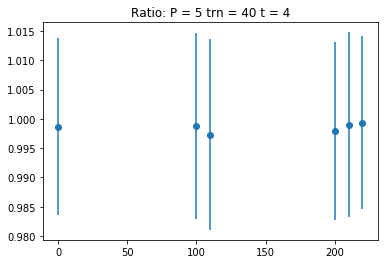

BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
BS: adding data at trn 50 t 3
BS: adding data at trn 50 t 4
BS: adding data at trn 40 t 3
BS: adding data at trn 40 t 4
Y = [0.9999909670270274, 0.9980289632012622, 0.9987120535236926, 1.0003935654223675] err=[0.01639433440052029, 0.015850927318232667, 0.01657297173359471, 0.0166308032903343]


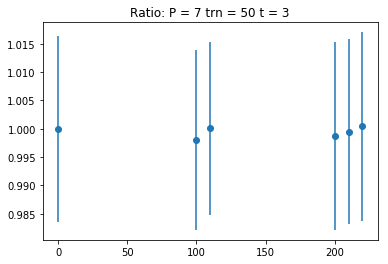

Y = [0.9143873877785452, 0.9058086049331928, 0.9125826627635794, 0.9135660904263716] err=[0.03634060644839943, 0.03610657962919052, 0.03787835419662509, 0.03537327692187615]


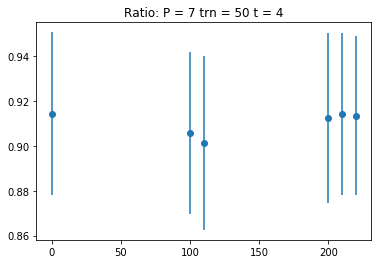

Y = [0.9997140590795395, 0.9994826508255558, 0.9989503671173536] err=[0.015459098710582977, 0.0153168405586497, 0.015124748899887942]


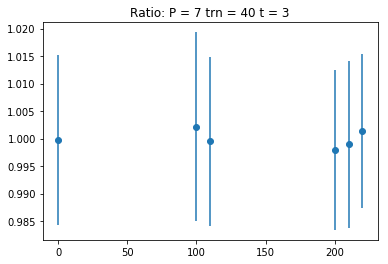

Y = [0.910346864257875, 0.9077139159213012, 0.9111849727065946] err=[0.03436438992083728, 0.03919314119296187, 0.03610873027065907]


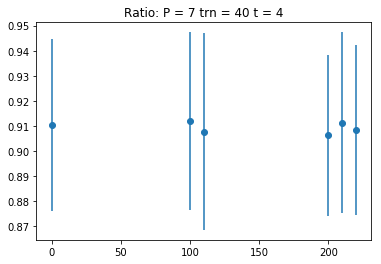

In [138]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as plot
import seaborn as sbn
import re
import math
from itertools import product

idir='/Users/ruizi/Documents/ML/outputs/pdf/'
dirjk = ['ML.06112019.006', 'ML.06112019.014']
key = ['50', '40']
dirbs = ['ML.06122019.0{:02d}'.format(i) for i in range(3, 13) ]
odir = '/Users/ruizi/Documents/ML/outputs/pdf/plots'
p = [ 5, 7 ]
trn = [ 50, 40 ]
q=0
for ch in [ '0', '2' ]:
    errl = {}
    ratiol = {}
    m = 0
    for d in dirjk:
        file = idir+d+'/JK.'+ch
        flag = 0
        tmpe = {}
        tmpr = {}
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            tmpe[nn[3]] = [float(nn[-1])]
                            tmpr[nn[3]] = [float(nn[4])]
            pf.close()
        errl[key[m]] = tmpe
        ratiol[key[m]] = tmpr
        m += 1
    m = 0
    for d in dirbs:
        file = idir+d+'/BS.'+ch
        flag = 0
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            errl[key[m]][nn[3]].append(float(nn[-1]))
                            ratiol[key[m]][nn[3]].append(float(nn[4]))
                            print("BS: adding data at trn {:} t {:}".format(key[m], nn[3]))
            pf.close()
        m += 1
        if m == len(key):
            m = 0
    m = 0
    for k in key:
        for T in ratiol[k]:
            l = len(ratiol[k][T])
            r = [ratiol[k][T][0]]
            e = [errl[k][T][0]]
            r.extend(ratiol[k][T][m+1::len(key)])
            e.extend(errl[k][T][m+1::len(key)])
            fig, ax = mplot.subplots()
            print('Y = {:} err={:}'.format(r, e))
            ax.errorbar([0, 100, 110, 200, 210, 220], ratiol[k][T], yerr=errl[k][T], barsabove=True, fmt='o', capthick=10)
            ax.set_title('Ratio: P = {:} trn = {:} t = {:}'.format(p[q], k, T))
            mplot.show()
            fig.savefig(odir+'/P{:}tn{:}t{:}.pdf'.format(p[q], k, T), format='pdf')
        m += 1
    q += 1